# TP n°1 : Gradient Stochastique et Perceptron

Dans un but d’expérimentation et de visualisation, il est plus aisé de travailler sur des données générées
artificiellement. Ainsi on considère ici des variables explicatives (features en anglais) de dimension deux.
Cela consiste à prendre p = 2 dans le formalisme ci-dessus.

In [151]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [115]:
###############################################################################
#               Impoort part
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from matplotlib import rc

###############################################################################
# Displaying labeled data
###############################################################################

symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

### *Q1)*  
- Étudiez la fonction rand_gauss(n, mu, sigmas) qui engendre n observations selon la loi normale
multi-dimensionnelle de moyenne le vecteur mu et de matrice de covariance la matrice diagonale de
diagonale sigmas = [σ1, σ2], 

- Générer ensuite
plusieurs jeux de données à l’aide des fonctions rand_bi_gauss, rand_clown et rand_checkers
pour différents paramètres d’entrée n,mu,sigma. Que renvoient ces fonctions ? À quoi correspond
la seconde variable de sortie ?

In [116]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """Sample  points from a Gaussian variable.

    Parameters
    ----------
    n : number of samples

    mu : centered

    sigma : standard deviation
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(mu + res * sigmas)

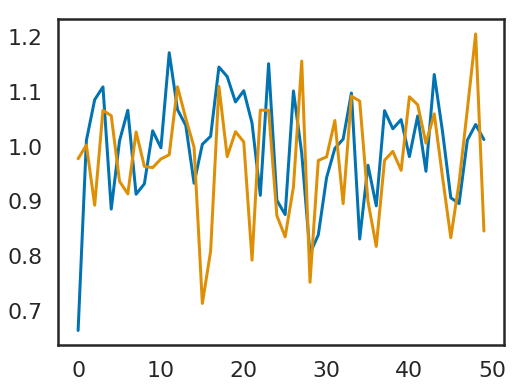

In [117]:
fig = plt.figure(figsize=(8,6))
plt.plot(rand_gauss(n=50))
plt.show()

Pour une seule distribution :

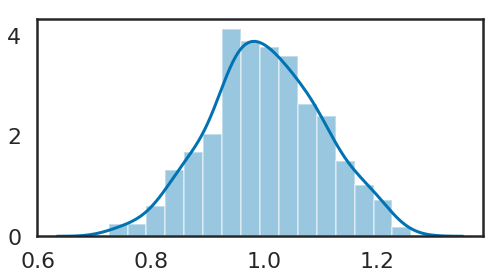

In [297]:
from scipy.stats import norm
import scipy.stats as stats

plt.figure(figsize=(8,4))
sns.distplot(rand_gauss(n=500, mu=[1.0], sigmas=0.1))
plt.show()

Pour les deux distributions :

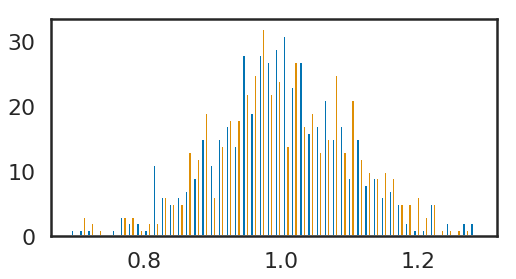

In [291]:
plt.figure(figsize=(8,4))
plt.hist(rand_gauss(n=500), bins=50)
plt.show()

In [293]:
import scipy.stats as stats
print("Skewness: %f" % stats.skew(rand_gauss()[0]))
print("Kurtosis: %f" % stats.kurtosis(rand_gauss()[0]))

#Les données sont pafaitement normalement distibuées car 
#elles sont générées à partir d'une loi normale mais qui n'est pas centrée-réduite

Skewness: 0.000000
Kurtosis: -2.000000


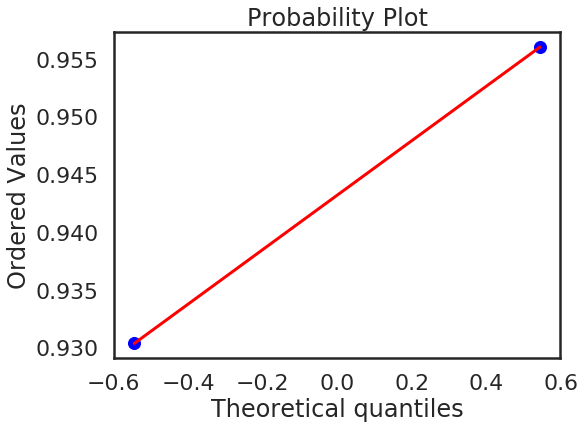

In [294]:
stats.probplot(rand_gauss()[0], plot=plt)
plt.show()

In [298]:
def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """Sample points from two Gaussian distributions.

    Parameters
    ----------
    n1 : number of sample from first distribution

    n2 : number of sample from second distribution

    mu1 : center for first distribution

    mu2 : center for second distribution

    sigma1: std deviation for first distribution

    sigma2: std deviation for second distribution
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

In [299]:
def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """Create samples and labels form a **clown** dataset.

    Parameters
    ----------
    n1 : number of sample from first blob

    n2 : number of sample from second blob

    sigma1 :  noise std deviation for the first blob

    sigma2 :  noise std deviation for the second blob
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

In [300]:
def rand_checkers(n1=100, n2=100, sigma=0.1):
    """Create samples and labels from a noisy checker.

    Parameters
    ----------
    n1 : number of samples for the first class

    n2 : number of samples for the second class
    """
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [-1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.random.permutation((nbp + nbn) * 8)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

Générer des jeux de données aléatoires :

In [301]:
mu = [0.5, 1.0]
sigma = [0.05, 0.1]

In [302]:
rand_bi_gauss()

(array([[-0.99666293, -0.94311944],
        [ 0.87342113,  0.92608833],
        [ 1.15575702,  1.08084163],
        [ 1.03856983,  1.12500662],
        [ 1.0466395 ,  0.96824815],
        [-0.98270173, -0.97578685],
        [-1.00134846, -0.98691031],
        [-1.07949826, -0.95859977],
        [ 0.96929917,  0.98984494],
        [ 0.85570385,  0.99816475],
        [ 0.93353588,  1.01650414],
        [ 1.12718274,  1.038249  ],
        [-1.17863073, -0.83309512],
        [ 1.06130378,  0.96298971],
        [ 0.83914029,  0.9386805 ],
        [-1.15264352, -1.15895867],
        [-1.05719275, -1.0289343 ],
        [ 1.03390368,  0.94772821],
        [ 1.07194086,  0.92228587],
        [-1.0177054 , -0.93700055],
        [ 1.02472614,  0.87006805],
        [-1.20473638, -1.00147018],
        [-1.05962483, -1.05795426],
        [-1.12465346, -1.00810932],
        [-1.07874237, -1.05100066],
        [ 0.90948097,  1.0760259 ],
        [ 0.94985517,  1.02312126],
        [-1.13725952, -1.057

Rand-bi-gauss génère des variables bi-variées gaussiennes. La deuxième sortie correspond à des 1 pour la première variale, et -1 pour la deuxième variable. Ce y correspond à des labels.

In [303]:
rand_clown()

(array([[-2.03013610e+00,  4.98504322e+00],
        [ 8.90736645e-01,  2.16204979e+00],
        [ 9.22398401e-01,  1.03435029e+00],
        [ 4.65163253e-01, -2.68485013e-01],
        [-1.94091143e+00,  3.50020564e+00],
        [-1.38985530e-01, -8.95201824e-01],
        [ 1.45707871e+00,  1.22801261e+00],
        [-1.04671083e+00,  2.31146985e+00],
        [ 3.79306104e+00,  3.78181869e+00],
        [-3.73102963e-01,  8.32565692e-01],
        [-1.46270172e+00,  1.80241241e+00],
        [ 7.60573563e-01,  5.18592375e-01],
        [-1.76360996e+00,  3.51575357e-01],
        [ 8.34649112e-01,  1.13466945e-01],
        [-1.64110888e+00,  3.17072315e+00],
        [ 2.14062708e+00,  6.24591209e+00],
        [-2.66718885e+00,  2.17929877e+00],
        [ 6.18782384e-01,  8.68826974e-01],
        [-3.82811424e+00,  1.64180329e+00],
        [-1.14110511e-01,  6.52732184e-01],
        [-1.99241687e+00,  3.70866022e+00],
        [ 1.48166124e+00,  1.62685092e+00],
        [-3.37135418e-01, -9.468

Le principe est le même pour rand_clown, et pour rand_checkers.

In [128]:
rand_checkers(n1=100, n2=100, sigma=0.1)

(array([[ 2.49898039e-01,  1.90289449e+00],
        [ 9.14526700e-01, -1.19198396e+00],
        [-1.03622448e+00, -2.69745385e-01],
        [-6.27734348e-01,  2.88941720e-01],
        [-3.44334542e-01,  1.03691084e+00],
        [-1.29581997e+00, -3.75360153e-01],
        [ 6.49501368e-01, -1.18147567e-01],
        [ 5.09090434e-01,  3.88715672e-01],
        [ 1.36998750e+00, -1.13052332e+00],
        [ 1.77729191e+00, -9.31678603e-01],
        [ 5.76407058e-01,  1.15095984e+00],
        [ 1.62378050e-02, -1.02252096e+00],
        [-8.82115894e-01, -1.67095626e+00],
        [ 2.10501546e+00,  8.93450866e-01],
        [-2.98553249e-01,  1.79859931e+00],
        [ 7.56223205e-01, -1.38475492e+00],
        [-9.37503122e-01, -5.00174843e-01],
        [-9.13348469e-01,  6.38696438e-01],
        [-1.09620814e+00,  1.65274136e+00],
        [ 3.51311064e-01,  1.74726025e+00],
        [ 1.72443528e+00,  5.40419047e-01],
        [-1.77994259e-01, -3.10721493e-01],
        [ 1.40560217e+00, -5.881

### *Q2)* 
Conservez quelques jeux de données afin de les utiliser dans la suite : pour chacun, il faudra sauver
sous forme d’un tableau numpy à deux colonnes X les données, et dans un vecteur Y les labels
correspondants à chaque exemple.

In [326]:
X_rand_bi, y_rand_bi = rand_bi_gauss()
X_rand_bi1, y_rand_bi1 = rand_bi_gauss(n1=200, n2=200, mu1=[0, 5], mu2=[2, -3], sigmas1=[0.3, 0.19],
                  sigmas2=[0.5, 0.9])
X_rand_bi2, y_rand_bi2 = rand_bi_gauss(n1=400, n2=200, mu1=[10, -3], mu2=[7, -1], sigmas1=[0.4, 0.8],
                  sigmas2=[0.3, 0.7])

In [327]:
X_rand_clown, y_rand_clown = rand_clown()
X_rand_clown1, y_rand_clown1 = rand_clown(n1=200, n2=400, sigma1=5, sigma2=2)
X_rand_clown2, y_rand_clown2 = rand_clown(n1=100, n2=100, sigma1=3, sigma2=3)

In [328]:
X_rand_checkers, y_rand_checkers = rand_checkers()
X_rand_checkers1, y_rand_checkers1 = rand_checkers(n1=100, n2=100, sigma=0.5)
X_rand_checkers2, y_rand_checkers2 = rand_checkers(n1=100, n2=100, sigma=1)

### *Q3)* 
Utilisez la fonction plot_2d disponible dans tp_perceptron_source.py et qui permet de visualiser
quelques jeux de données en fonction des étiquettes associées. Changer la couleur de la classe des
−1.

In [329]:
###############################################################################
#            Displaying labeled data
###############################################################################
symlist = ['o', 's', '+', 'x', 'D', '*', 'p', 'v', '-', '^']
collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
           'fuchsia']


def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """2D dataset data ploting according to labels.

    Parameters
    ----------

    X : data features

    y : label vector

    w :(optional) the separating hyperplan w

    alpha_choice : control alpha display parameter
    """
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1], c=np.array([color_blind_list[label_num]]),
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

### a. Rand-Bi

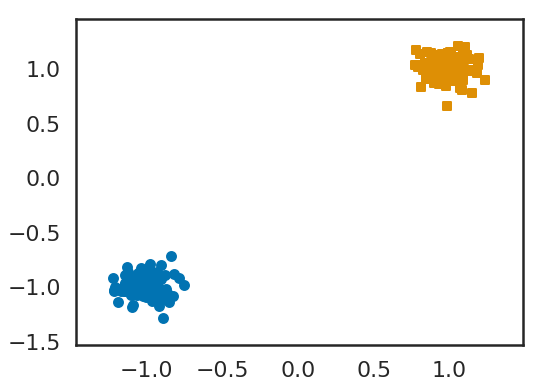

In [330]:
plot_2d(X_rand_bi, y_rand_bi)
plt.show()

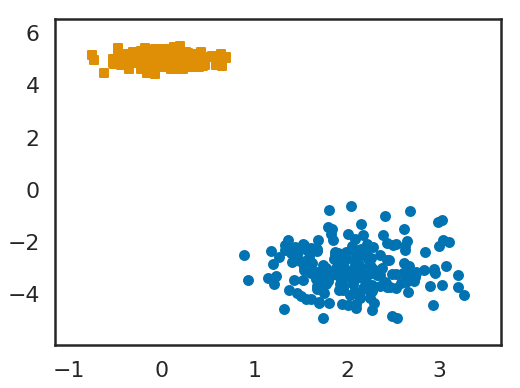

In [331]:
plot_2d(X_rand_bi1, y_rand_bi1)
plt.show()

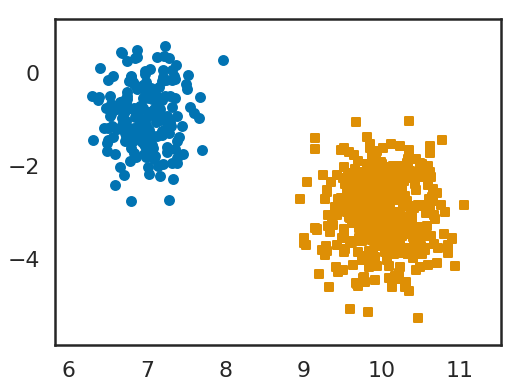

In [332]:
plot_2d(X_rand_bi2, y_rand_bi2)
plt.show()

### b. Rand-Clown

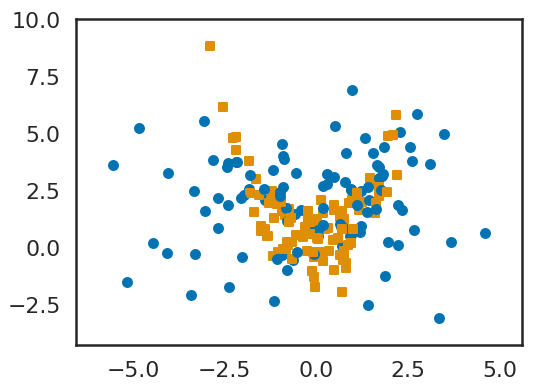

In [334]:
plot_2d(X_rand_clown, y_rand_clown)
plt.show()

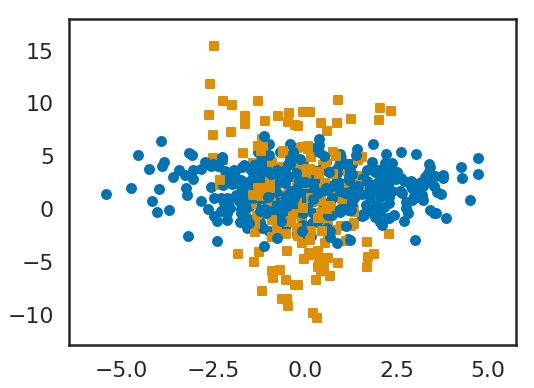

In [335]:
plot_2d(X_rand_clown1, y_rand_clown1)
plt.show()

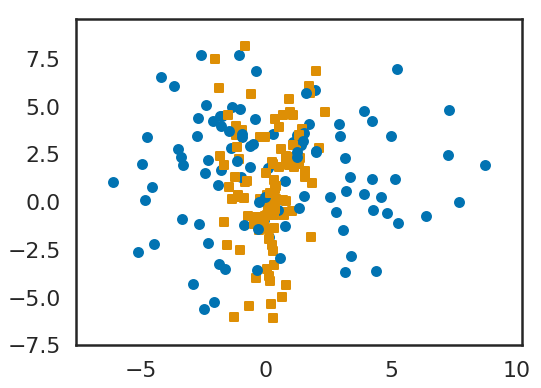

In [336]:
plot_2d(X_rand_clown2, y_rand_clown2)
plt.show()

### c. Rand_checkers

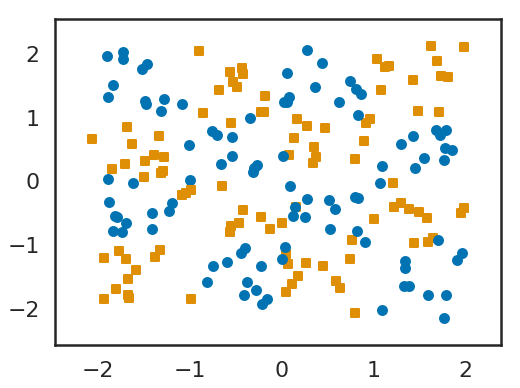

In [337]:
plot_2d(X_rand_checkers, y_rand_checkers)

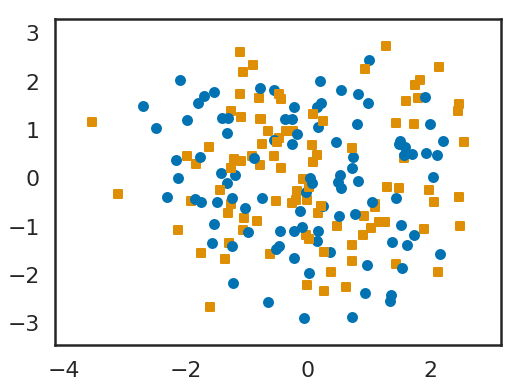

In [338]:
plot_2d(X_rand_checkers1, y_rand_checkers1)

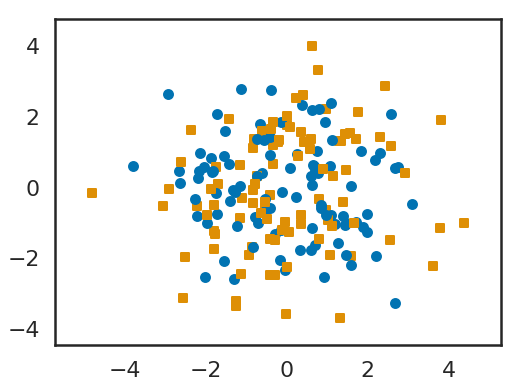

In [339]:
plot_2d(X_rand_checkers2, y_rand_checkers2)

### Les classifieurs linéaires (affines)

### *Q1)* 
A quoi correspond la frontière de décision du perceptron en dimension p = 2 ? Trouvez (à la main)
une bonne séparatrice sur les trois jeu de données simulées. Quand est-ce que fw(x) est grand ?
négatif ? positif ? Quelle est la signification géométrique de cette fonction ? À quoi correspond w0 ?

La frontière de décision du perceptron correspond à une fonction affine en dimension p=2. w0 correspond à l'ordonnée à l'origine de cette fonction.

In [254]:
%%latex

\begin{equation}
\hat{f}_w = {w}_0 + \sum({w}_j*x_j)
\end{equation}
\begin{equation}
Le \ terme \ \sum({w}_j*x_j) \ correspond \ à \ la \  projection\  des \ observations\ x \ sur \ le \ verteur \ normal\ W.
\end{equation}
\begin{equation} De\ ce \ fait, \ \hat{f}_w \ est \ grand \ lorsque \ les \ observations \ x sont\ loin \ de\ l'hyperplan\ H_x.
\end{equation}

<IPython.core.display.Latex object>

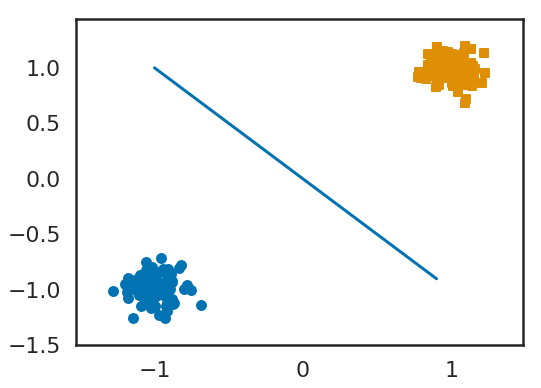

In [159]:
#Rand_bi
plot_2d(X_rand_bi, y_rand_bi)
x = np.arange(-1, 1,0.1)
fx = -1 * x
plt.plot(x, -x)
plt.show()

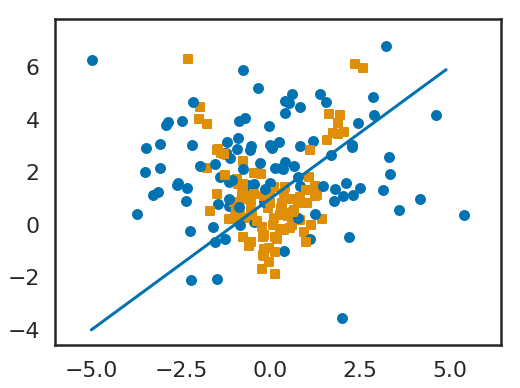

In [164]:
#Clown
plot_2d(X_rand_clown, y_rand_clown)
x = np.arange(-5, 5,0.1)
plt.plot(x, x+1)
plt.show()

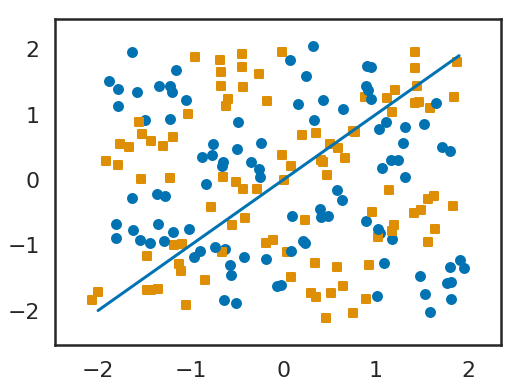

In [166]:
#Checker
plot_2d(X_rand_checkers, y_rand_checkers)
x = np.arange(-2, 2,0.1)
plt.plot(x, x)
plt.show()

### *Q2)* 
Vérifiez que la fonction predict(x,w) prend en entrée un vecteur x ∈ Rp et un vecteur poids w ∈ Rp+1 et renvoie le vecteur de prédiction fw(x). 

Vérifiez ensuite que predict_class(x,w) renvoie bien l’étiquette prédite sign(fw(x))

In [412]:
###############################################################################
#               Loss functions and their gradient
###############################################################################

def predict(x, w):
    """Prediction from a normal vector."""
    return np.dot(x, w[1:]) + w[0]

In [413]:
def predict_class(x, w):
    """Predict a class from at point x thanks to a normal vector."""
    return np.sign(predict(x, w))

In [429]:
x = [-1,3,-8,0]
w = [0.1,0.1,0.5,0.2,0.1]

In [430]:
predict(x, w)

-0.10000000000000017

In [431]:
predict_class(x,w)

-1.0

### *Q3)* 
Supposons que x ∈ Rp et y ∈ R soient fixes. Quelle est la nature des fonctions :

- Rp+1 → R+ 

- w → l(fw(x), y) 

pour les trois pertes étudiées : constante, linéaire, quadratique, constante par morceaux, linéaire
par morceaux, quadratique par morceaux, etc. ?

In [437]:
def zero_one_loss(x, y, w):
    """0-1 loss function."""
    return abs(y - np.sign(predict(x, w))) / 2.

In [438]:
def hinge_loss(x, y, w):
    """Hinge loss function."""
    return np.maximum(0., 1. - y * predict(x, w))

In [439]:
def mse_loss(x, y, w):
    """Mean square error loss."""
    return (y - predict(x, w)) ** 2

In [454]:
x = np.linspace(-3,5,201)
y = np.linspace(-5,5,201)
w = np.hstack((0, np.random.dirichlet(np.ones(201),size=1)[0]))

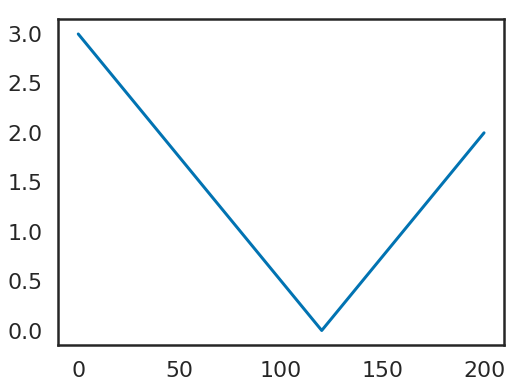

In [455]:
plt.plot(zero_one_loss(x,y,w))
plt.show()

La fonction n'est pas continue, elle est linéaire par morceaux.

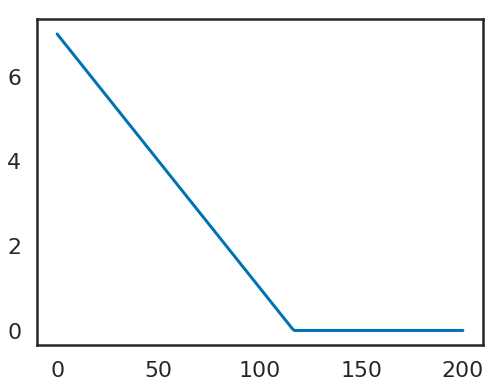

In [456]:
plt.plot(hinge_loss(x,y,w))
plt.show()

La fonction Hinge Loss est continue à gauche, et constante à droite.

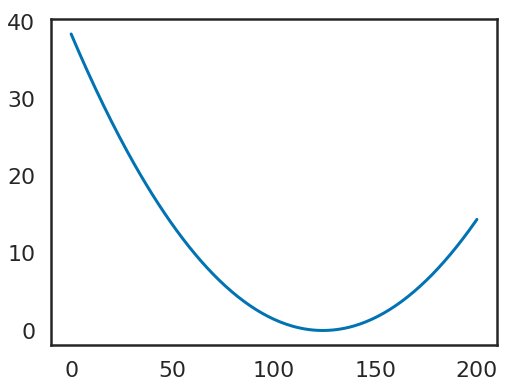

In [457]:
plt.plot(mse_loss(x,y,w))
plt.show()

La fonction MSE loss est une fonction quadratique. 

# Algorithme de descente de gradient stochastique

### *Q4)* 
Décrire un pseudo algorithme “Perceptron version aléatoire”, une variante qui visite les observations
en effectuant un tirage aléatoire uniforme (faire le cas avec remise et sans remise). On ne demande
pas de re-coder cette fonction ici. C’est cette version qui est généralement appelée méthode de
descente de gradient stochastique. Remarquez que c’est celle qui est proposée par défaut dans la
fonction gradient.

In [447]:
def norm2(x, y, w):
    """Squared norm of a vector."""
    return np.dot(w, w)


def gr_hinge_loss(x, y, w):
    """Sub-gradient of the loss function hingeloss."""
    return np.dot(-y * (hinge_loss(x, y, w) > 0.),
                  np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_mse_loss(x, y, w):
    """Gradient of the least squares lost function."""
    return -2. * np.dot(y - predict(x, w),
                        np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_norm2(x, y, w):
    """Gradient of the squared norm."""
    return 2. * w


def pen_loss_aux(x, y, w, l):
    """Loss function penalized by hinge loss."""
    return hinge_loss(x, y, w) + l * norm2(x, y, w)


def gr_pen_loss_aux(x, y, w, l):
    """Gradient of hinge loss penalized loss function."""
    return gr_hinge_loss(x, y, w) + l * gr_norm2(x, y, w, )


def pen_loss(l):
    """Penalized loss function."""
    return lambda x, y, w: pen_loss_aux(x, y, w, l)


def gr_pen_loss(l):
    """Gradient penalized loss function."""
    return lambda x, y, w: gr_pen_loss_aux(x, y, w, l)

Pseudo Algorithme :
- Données : Observation et leurs étiquettes, le pas de gradient e, le nombre maximal d'itérations n_iter, un nombre n d'observations sélectionnées.
- Initialiser aléatoirement w, initialiser j = 0
- Tant que j < n_iter :
    - w <- w
    - Tirer aléatoirement n couples (Xi, Yi) :
    - Pour i allant de 1 à n :
        - w <- w - e * ∇w l(fw(Xi),yi)
- j = j + 1

### *Q5)* 
On va observer graphiquement avec plot_gradient l’évolution de 1/n * Somme(l(fw(xi), yi) selon w suivant les étapes de l’algorithme. 

La descente de gradient simple est aussi appelée batch (i.e., lot ou
stock en français), et consiste à calculer le vrai gradient 1/n ∇w l(fw(xi), yi). 

Lancer l’exemple avec et sans l’option stochastique. Pourquoi le nombre d’itérations est niter * len(y1) pour le cas stochastique ?

In [464]:
###############################################################################
#            Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """Frontiere plotting for a decision function f."""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()


def frontiere_new(clf, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True, n_labels=3, n_neighbors=3):
    """Trace la frontiere pour la fonction de decision de clf."""
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    XX = np.c_[xx.ravel(), yy.ravel()]
    print(XX.shape)
    z = clf.predict(XX)
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    # color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    # sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)
    plt.title("L=" + str(n_labels) + ",k=" +
              str(n_neighbors))


def frontiere_3d(f, data, step=20):
    """Plot the 3d frontiere for the decision function f."""
    ax = plt.gca(projection='3d')
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    ax.plot_surface(xx, yy, z, rstride=1, cstride=1,
                    linewidth=0., antialiased=False,
                    cmap=plt.cm.coolwarm)


def plot_cout(X, y, loss_fun, w=None):
    """Plot the cost function encoded by loss_fun,

    Parameters
    ----------
    X : data features
    y :  labels
    loss_fun : loss function
    w : (optionnal) can be used to give a historic path of the weights """
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(X, y, ww).mean()
    datarange = np.array([[np.min(X[:, 0]), np.min(X[:, 1])],
                          [np.max(X[:, 0]), np.max(X[:, 1])]])
    frontiere(_inter, np.array(datarange))
    if w is not None:
        plt.plot(w[:, 1], w[:, 2], 'k')
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])


def plot_cout3d(x, y, loss_fun, w):
    """ trace le cout de la fonction cout loss_fun passee en parametre, en x,y,
        en faisant varier les coordonnees du poids w.
        W peut etre utilise pour passer un historique de poids"""
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(x, y, ww).mean()

    datarange = np.array([[w[:, 1].min(), w[:, 2].min()],
                         [w[:, 1].max(), w[:, 2].max()]])
    frontiere_3d(_inter, np.array(datarange))
    plt.plot(w[:, 1], w[:, 2], np.array([_inter(w[i, 1:]) for i in
             range(w.shape[0])]), 'k-', linewidth=3)


In [465]:
def gradient(x, y, eps, niter, w_ini, loss_fun, gr_loss_fun, stochastic=True):
    """ algorithme de descente du gradient:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        - loss_fun : fonction de cout
        - gr_loss_fun : gradient de la fonction de cout
        - stoch : True : gradient stochastique
        """
    w = np.zeros((niter, w_ini.size))
    w[0] = w_ini
    loss = np.zeros(niter)
    loss[0] = loss_fun(x, y, w[0]).mean()
    for i in range(1, niter):
        if stochastic:  # this is for Stochastic Gradient Descent
            idx = [np.random.randint(x.shape[0])]
        else:           # this is for pure Gradient Descent
            idx = np.arange(x.shape[0])
        w[i, :] = w[i - 1, :] - eps * gr_loss_fun(x[idx, :],y[idx], w[i - 1, :])
        loss[i] = loss_fun(x, y, w[i, :]).mean()
    return w, loss

In [466]:
def plot_gradient(X, y, wh, cost_hist, loss_fun):
    """ display 4 figures on how  (stochastic) gradient descent behaves
    wh : solution history
    cost_hist : cost history
    loss_fun : loss function
    """
    best = np.argmin(cost_hist)
    plt.subplot(221)
    plt.title('Data and hyperplane estimated')
    plot_2d(X, y, wh[best, :])
    plt.subplot(222)
    plt.title('Projection of level line and algorithm path')
    plot_cout(X, y, loss_fun, wh)
    plt.subplot(223)
    plt.title('Objective function vs iterations')
    plt.plot(range(cost_hist.shape[0]), cost_hist)
    plt.subplot(224, projection='3d')
    plt.title('Level line and algorithm path')
    plot_cout3d(X, y, loss_fun, wh)

Non-stochastique :

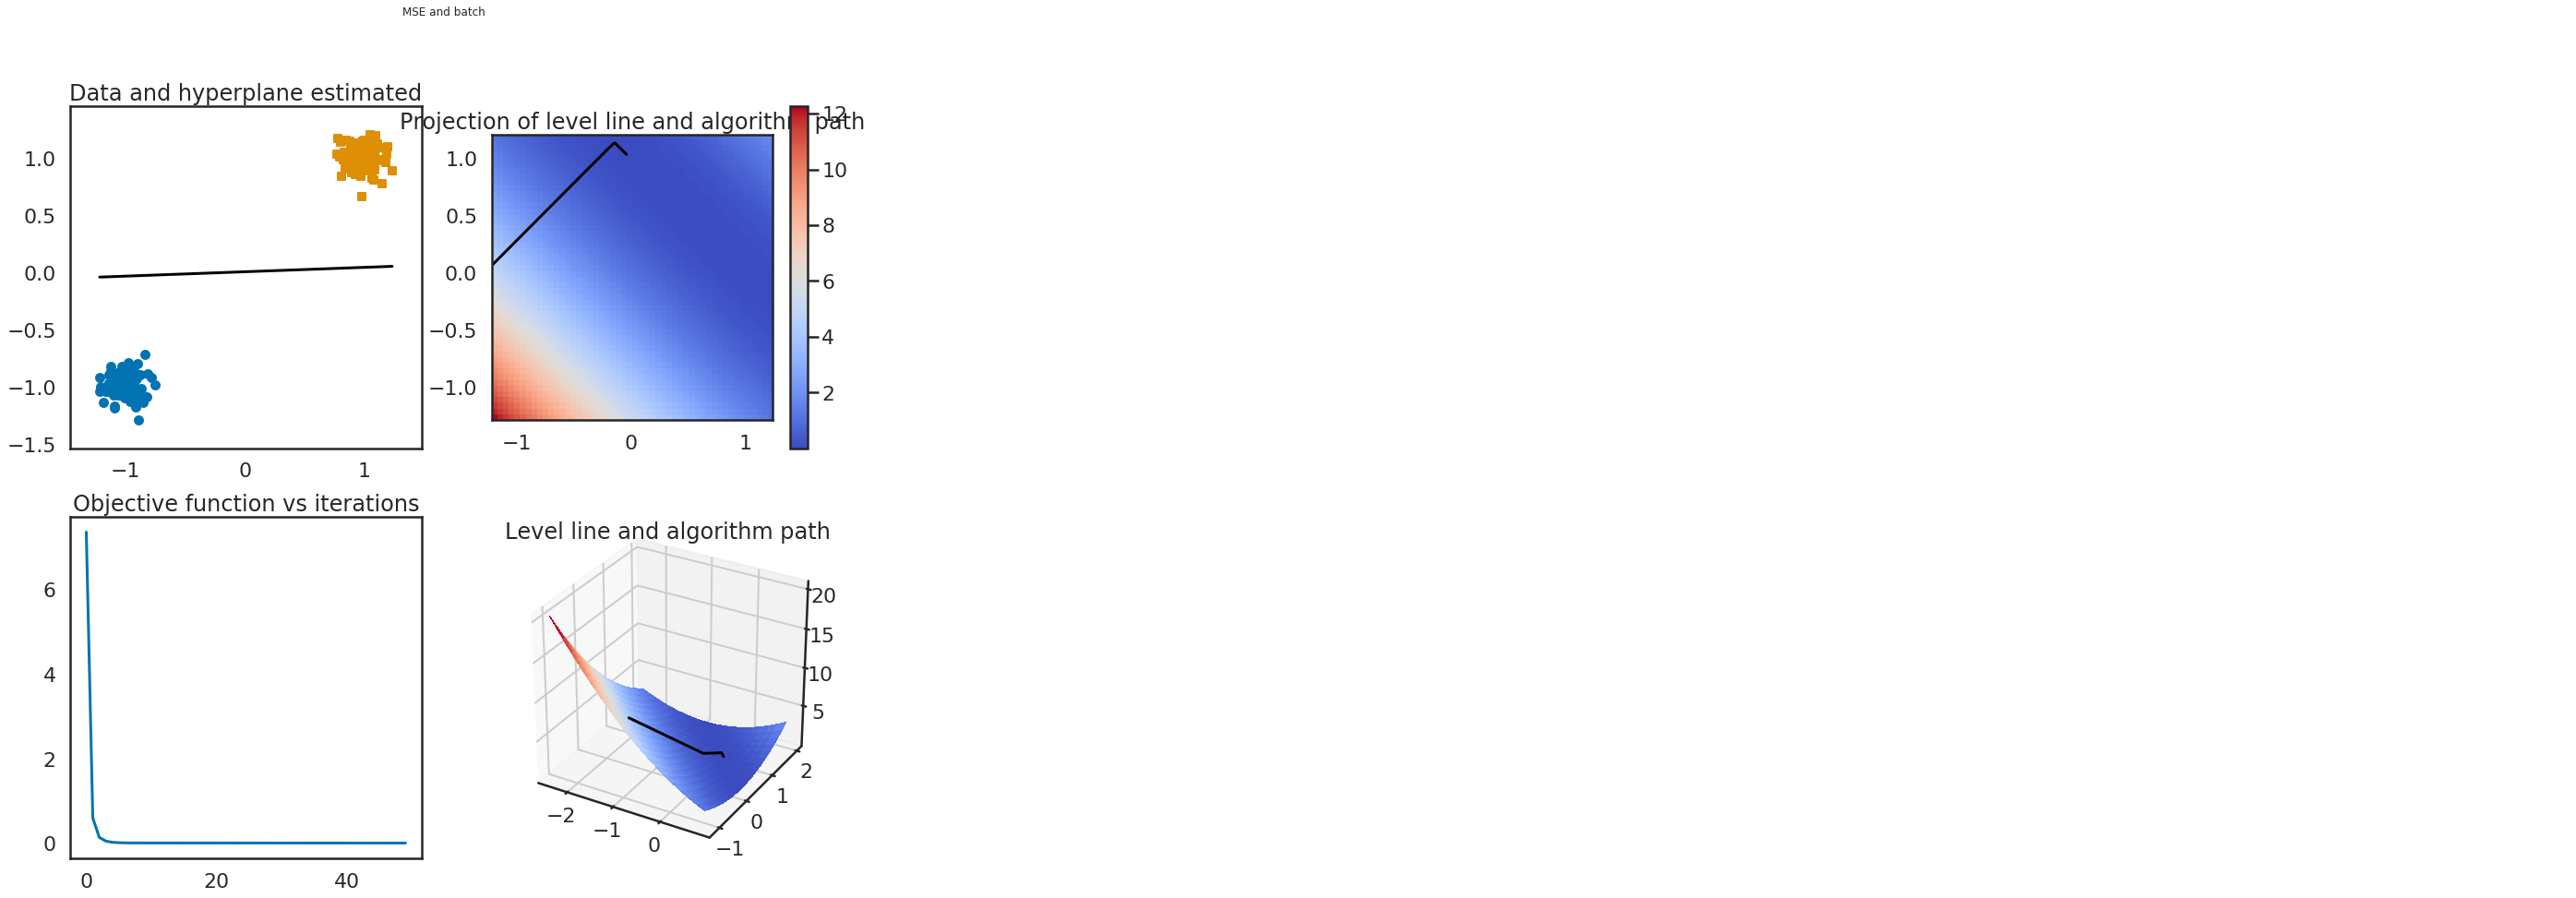

In [478]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_bi.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_bi, y_rand_bi, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_bi, y_rand_bi, wh, costh, lfun)
plt.suptitle('MSE and batch', fontsize=12)
plt.show()

Stochastique :

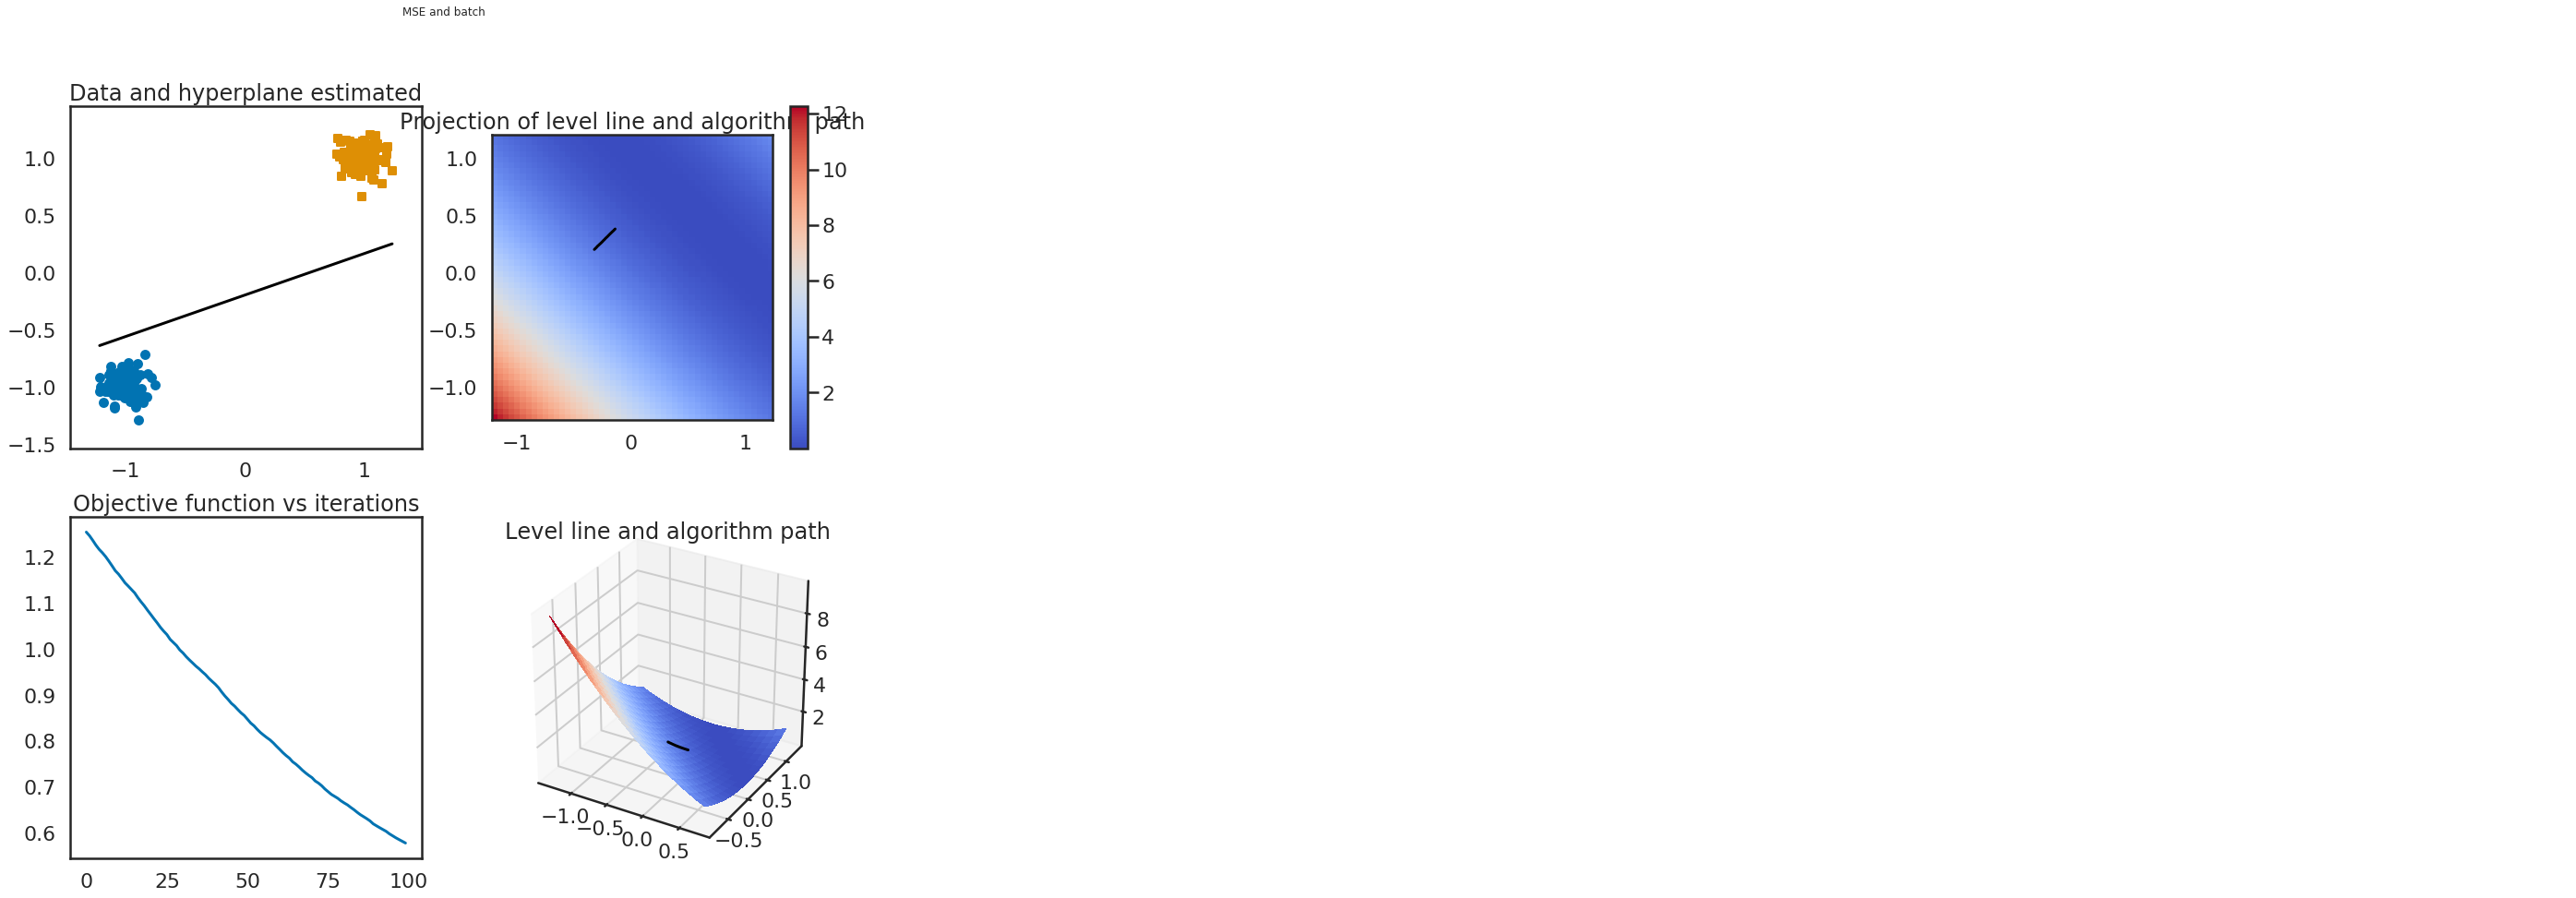

In [488]:
epsilon = 0.001
niter = 100
w_ini = np.random.randn(X_rand_bi.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_bi, y_rand_bi, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_bi, y_rand_bi, wh, costh, lfun)
plt.suptitle('MSE and batch', fontsize=12)
plt.show()

Dans le cas stochastique, le nombre d'itération selon l'algorithme de descente de gradient est :
- pour chacune des n itérations, on sélectionne un index de X au hasard
- et on calcule la fonction de perte de sur tout le domaine de y (donc len(y))

### *Q6)* 
Expérimentez sur différents jeux de données : utiliser soit les fonctions fournies dans le fichier
source, soit la fonction de sklearn. Étudiez les performances selon les points suivants : le nombre
d’itérations, la fonction de coût, la difficulté du problème (si les classes sont facilement séparables ou
non par un hyperplan). Observez-vous des comportements étranges, si oui quelle en est la raison ?

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

(40000, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

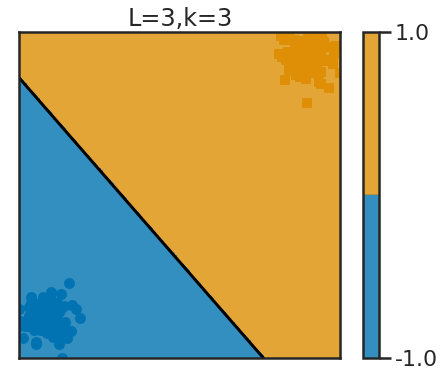

In [543]:
# Sklearn SGD:
from sklearn import linear_model

clf = linear_model.SGDClassifier(max_iter=10)
clf.fit(X_rand_bi, y_rand_bi)
plt.figure(5)
wsgd = [clf.intercept_[0], clf.coef_[0, 0], clf.coef_[0, 1]]
frontiere_new(clf, X_rand_bi, y_rand_bi, wsgd, step=200, alpha_choice=1)
plt.show()

Selon le nombre d'itérations :

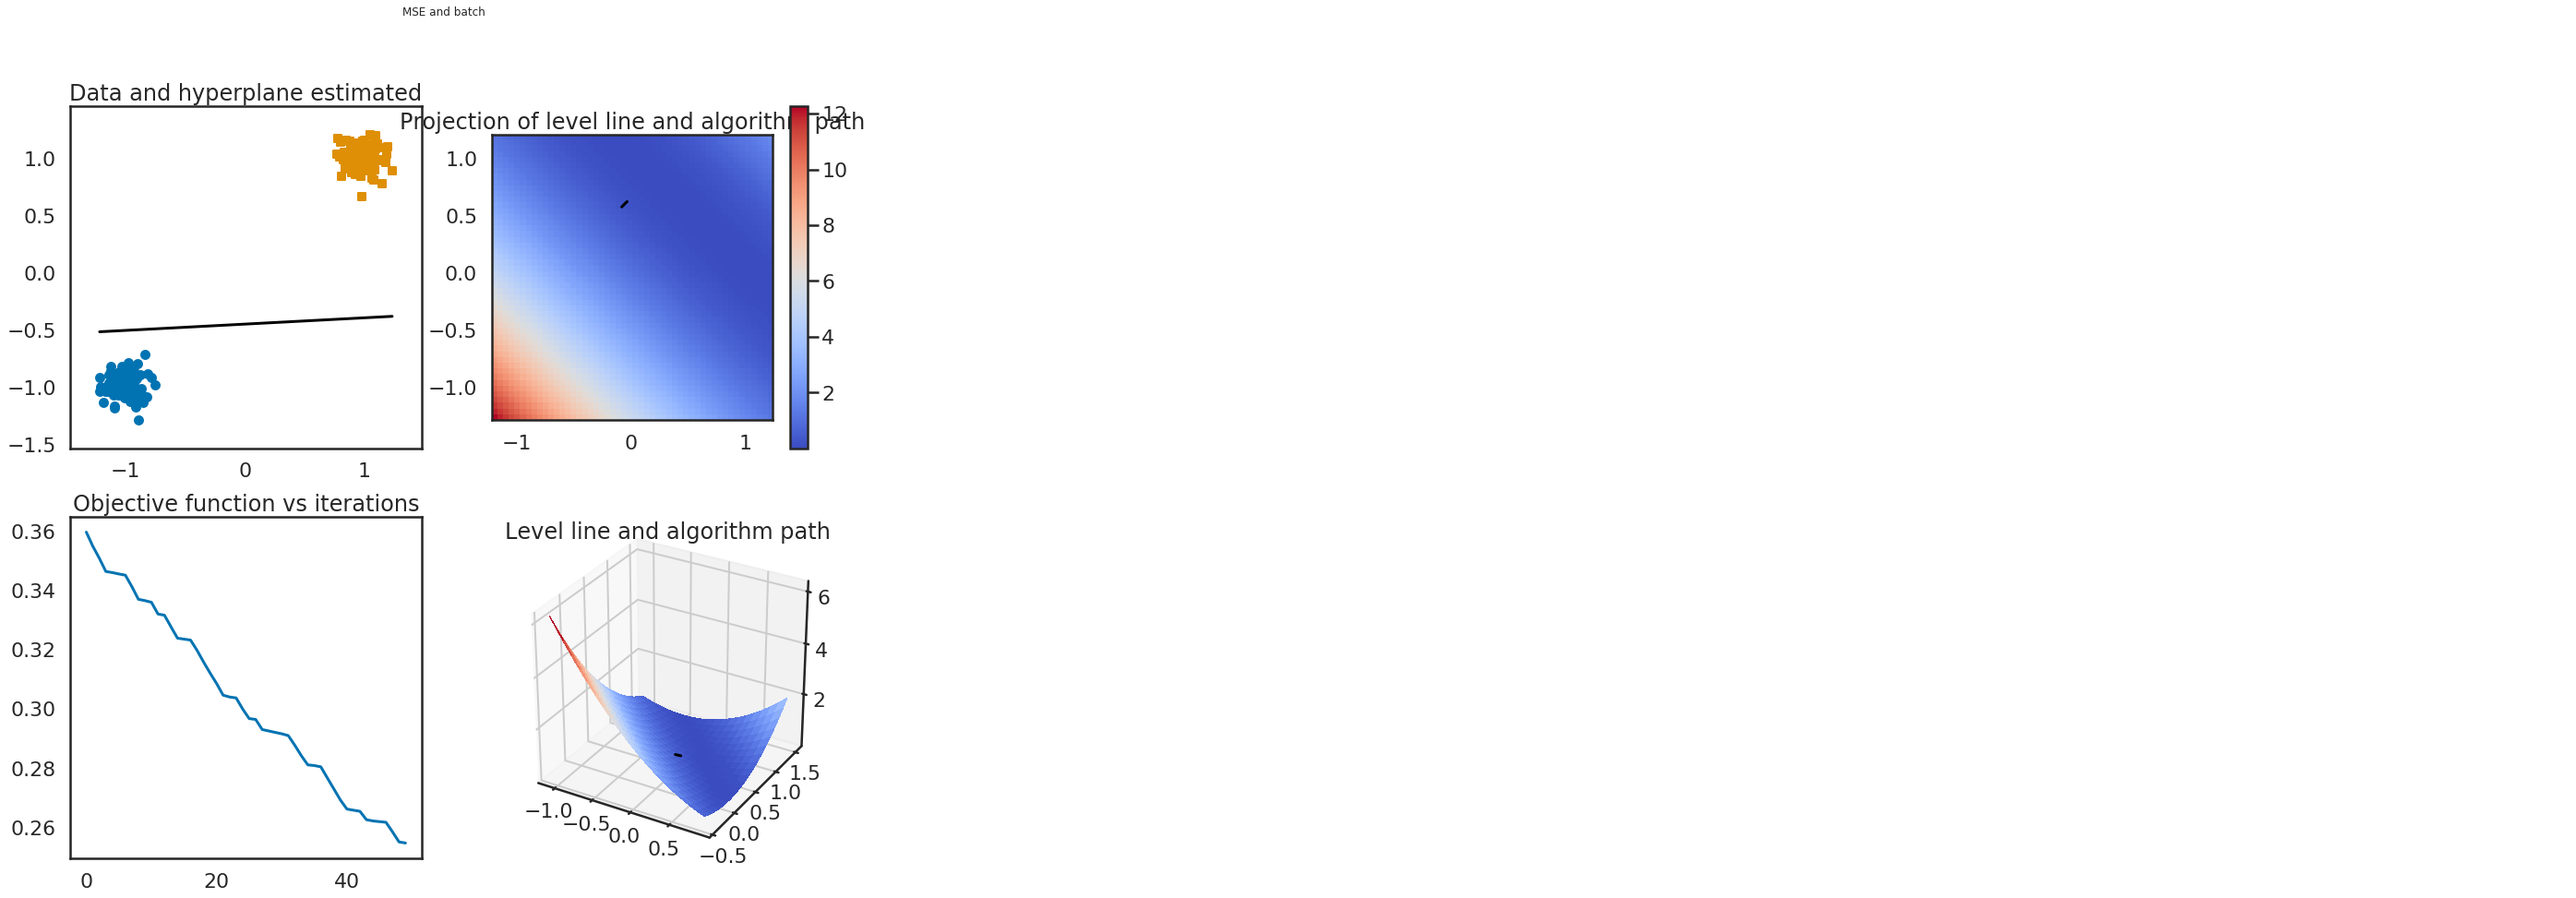

In [512]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_bi.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_bi, y_rand_bi, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_bi, y_rand_bi, wh, costh, lfun)
plt.suptitle('MSE and Stochastic', fontsize=12)
plt.show()

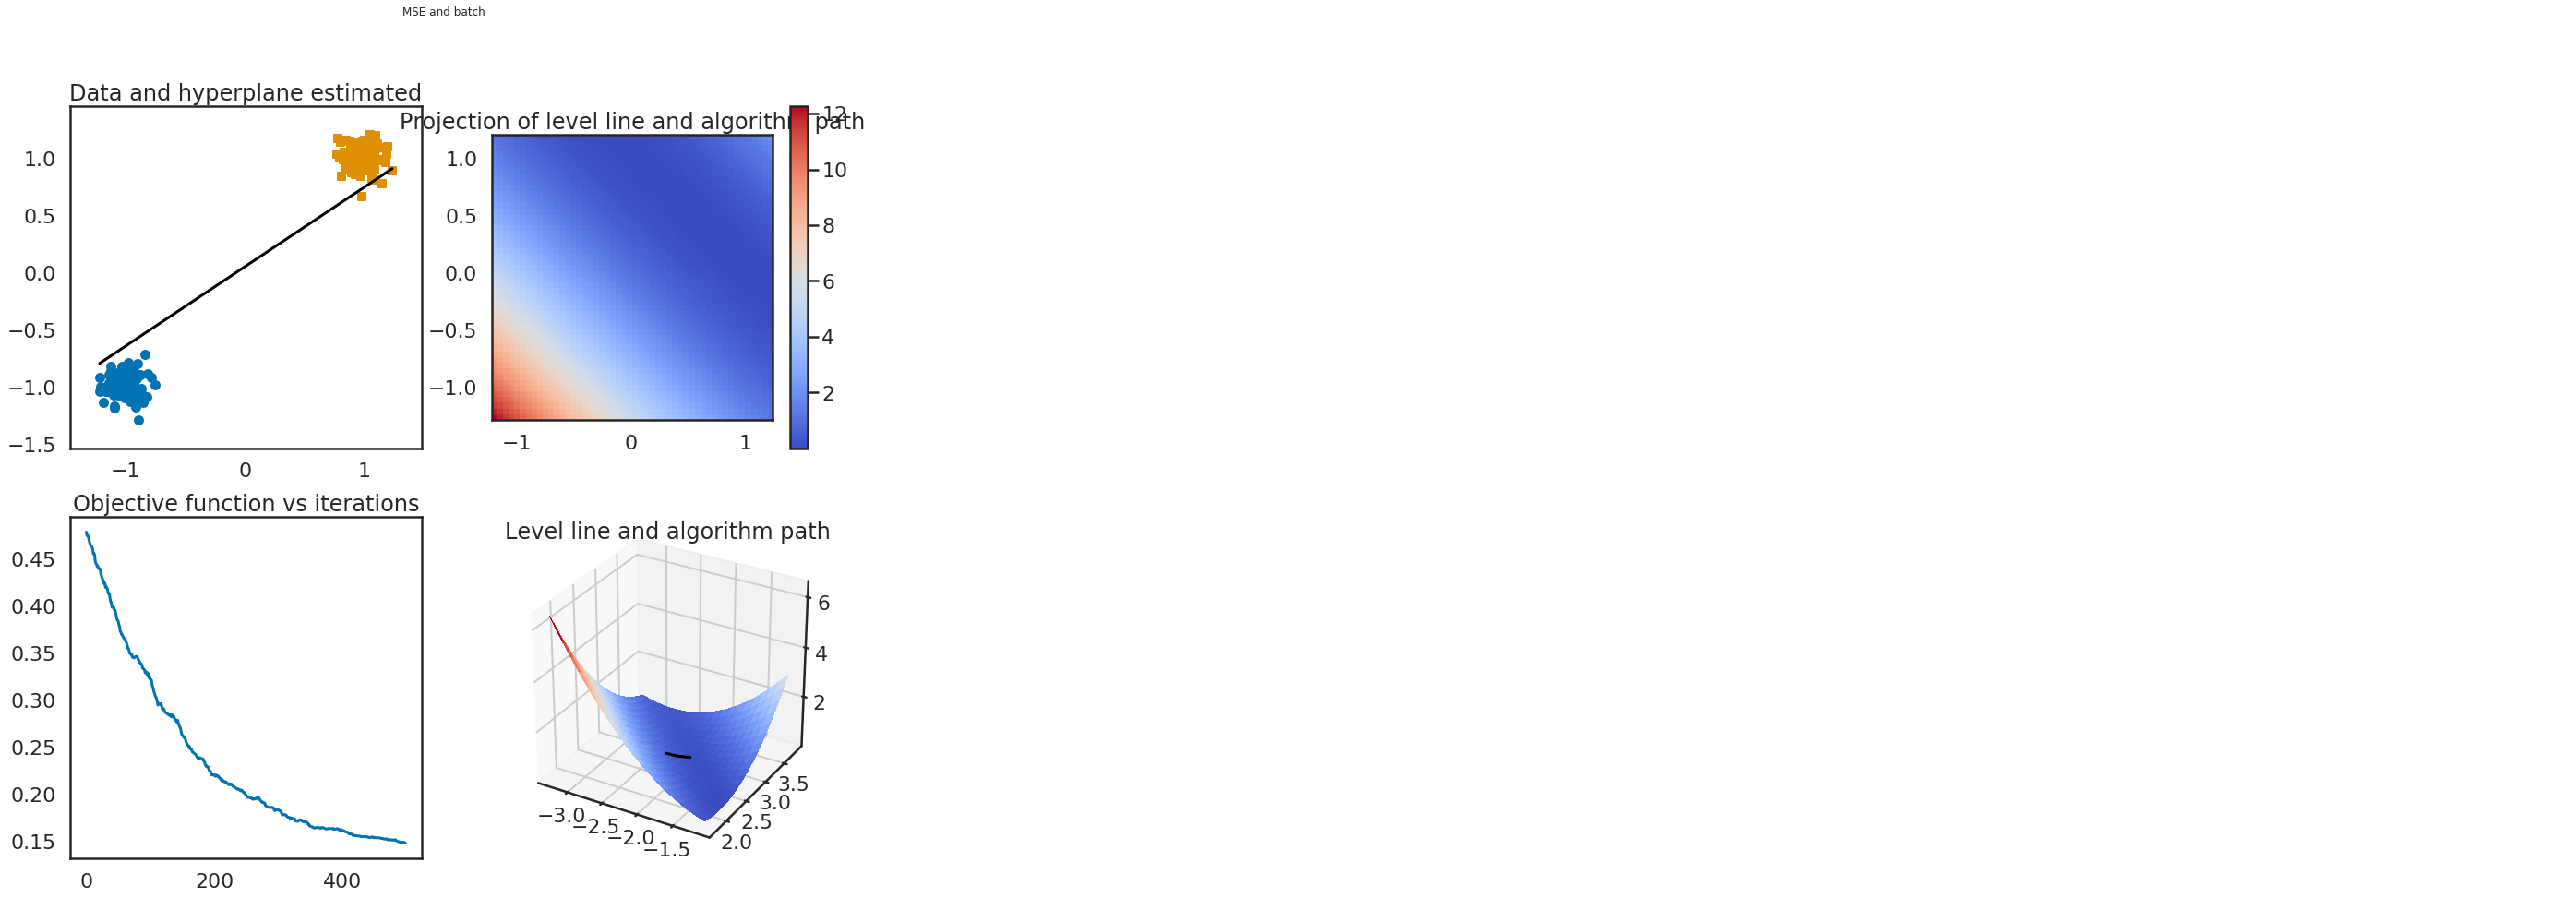

In [513]:
epsilon = 0.001
niter = 500
w_ini = np.random.randn(X_rand_bi.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_bi, y_rand_bi, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_bi, y_rand_bi, wh, costh, lfun)
plt.suptitle('MSE and Stochastic', fontsize=12)
plt.show()

Selon la séparabilité des classes :

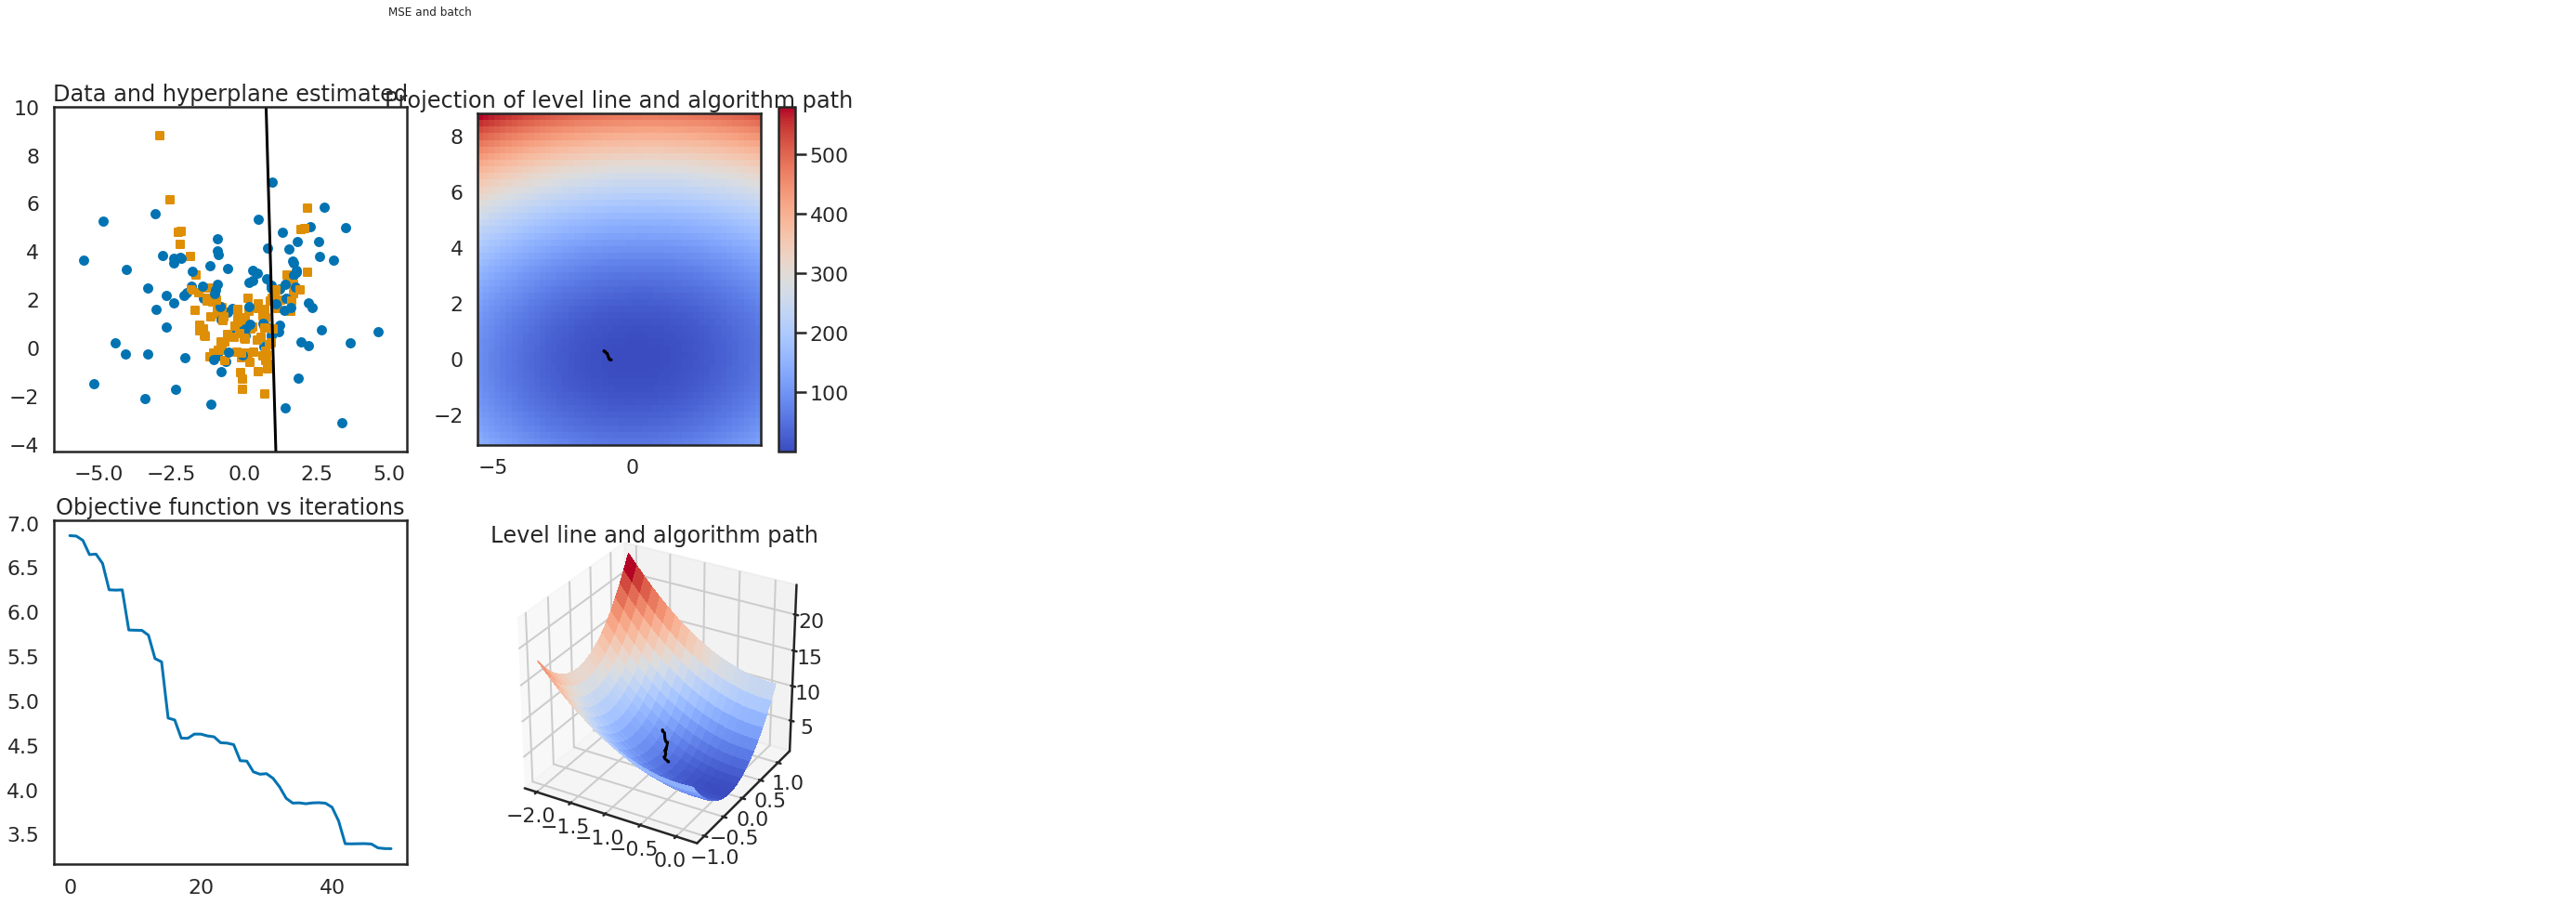

In [514]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_clown, y_rand_clown, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_clown, y_rand_clown, wh, costh, lfun)
plt.suptitle('MSE and Stochastic', fontsize=12)
plt.show()

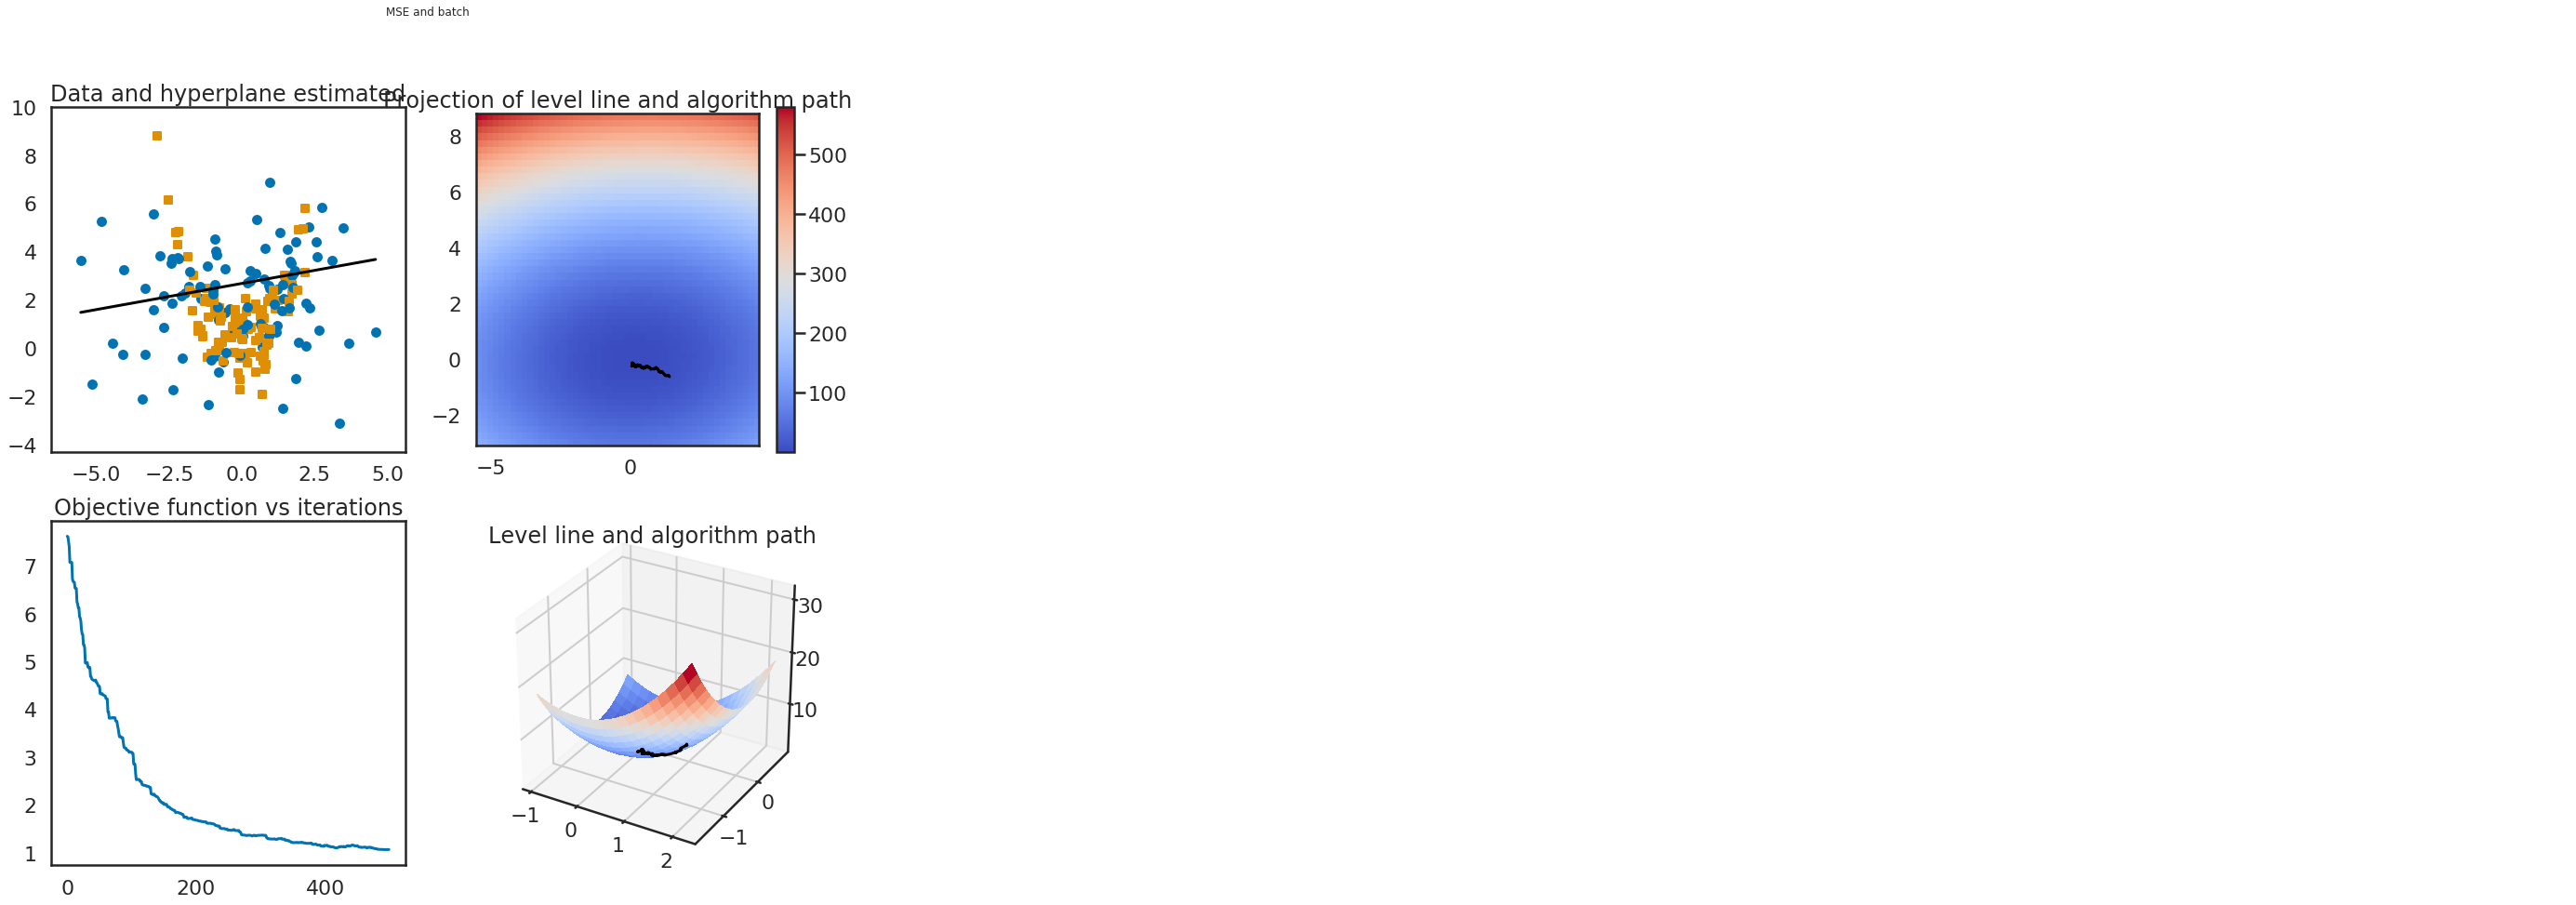

In [515]:
epsilon = 0.001
niter = 500
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_clown, y_rand_clown, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_clown, y_rand_clown, wh, costh, lfun)
plt.suptitle('MSE and Stochastic', fontsize=12)
plt.show()

Selon la fonction de coût :

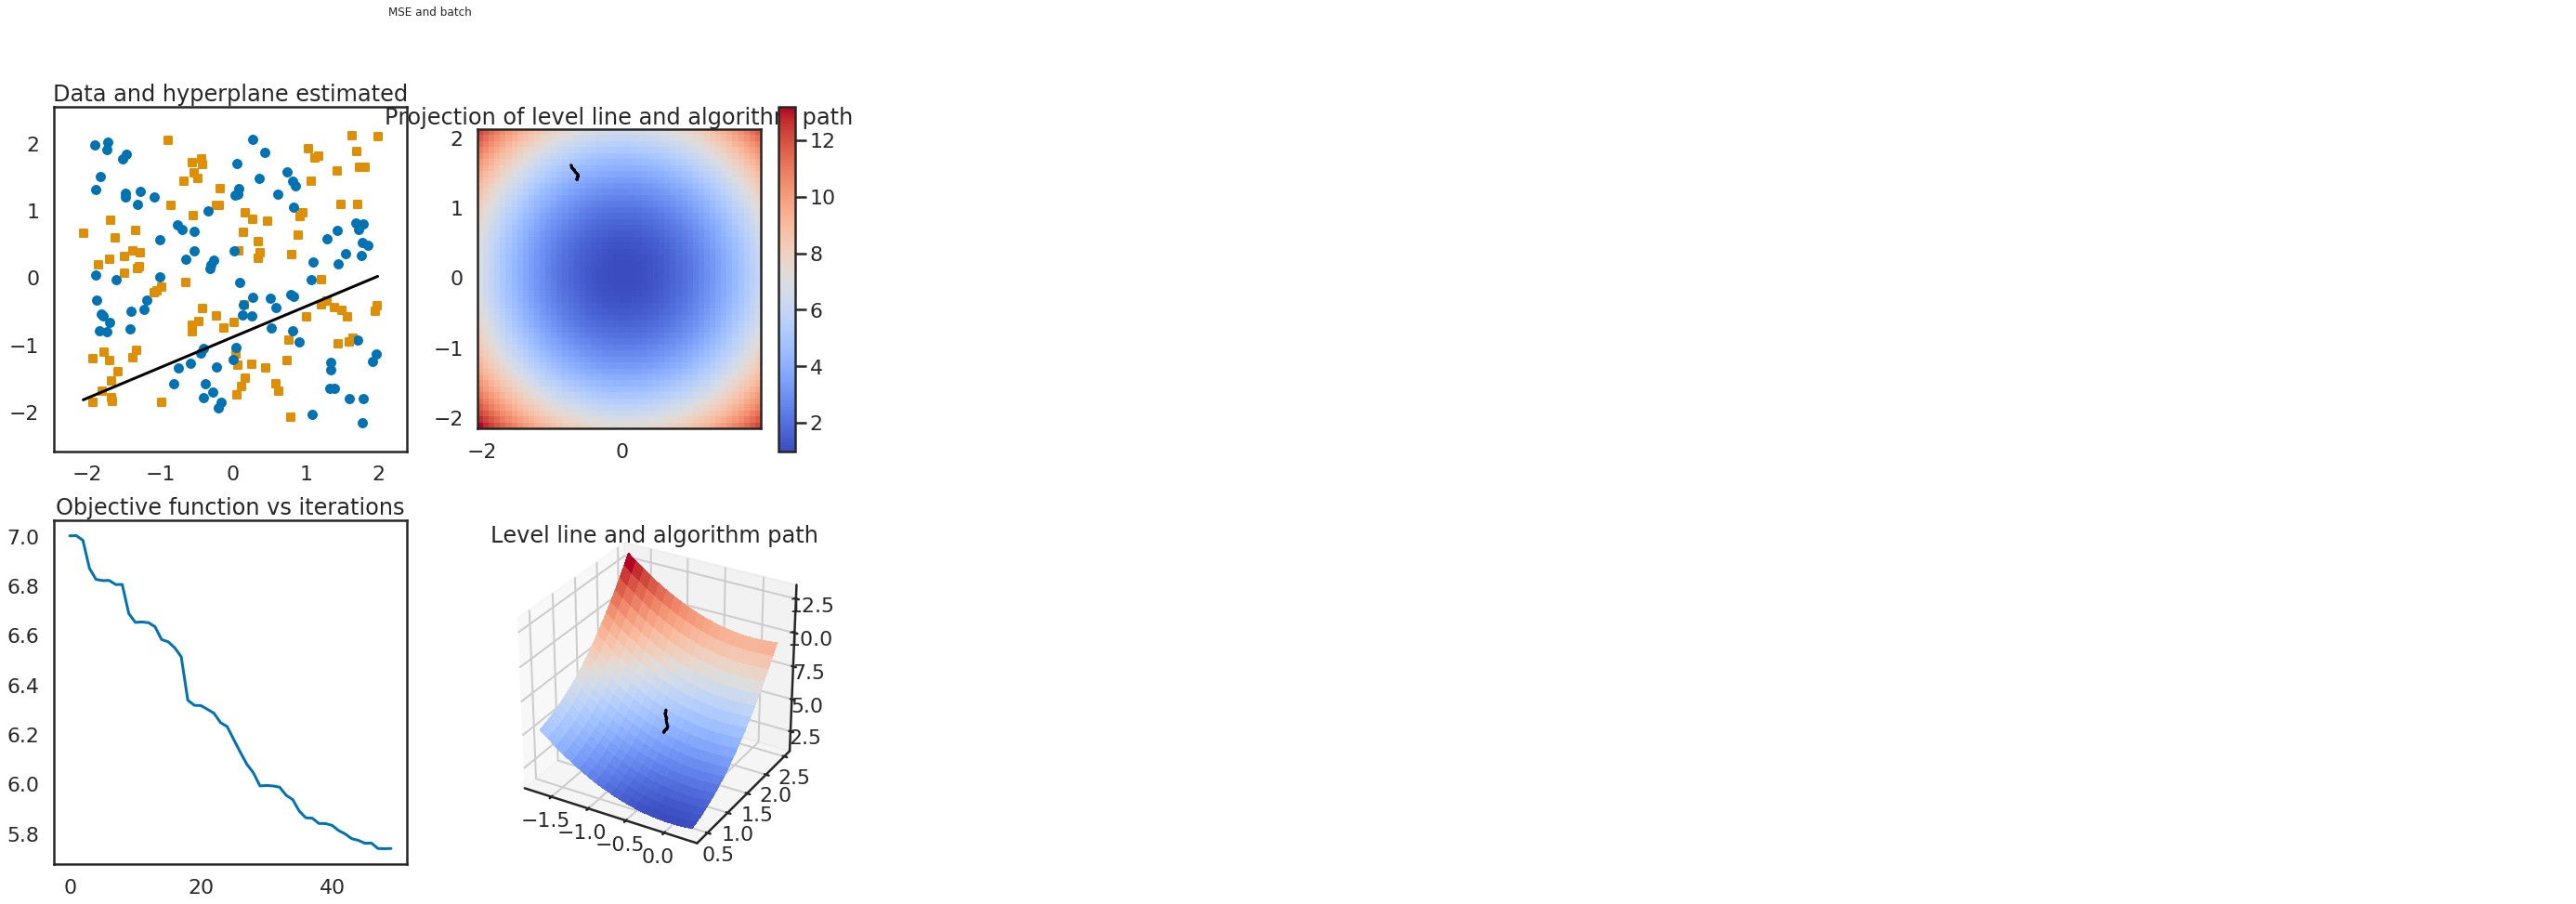

In [511]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('MSE and Stochastic', fontsize=12)
plt.show()

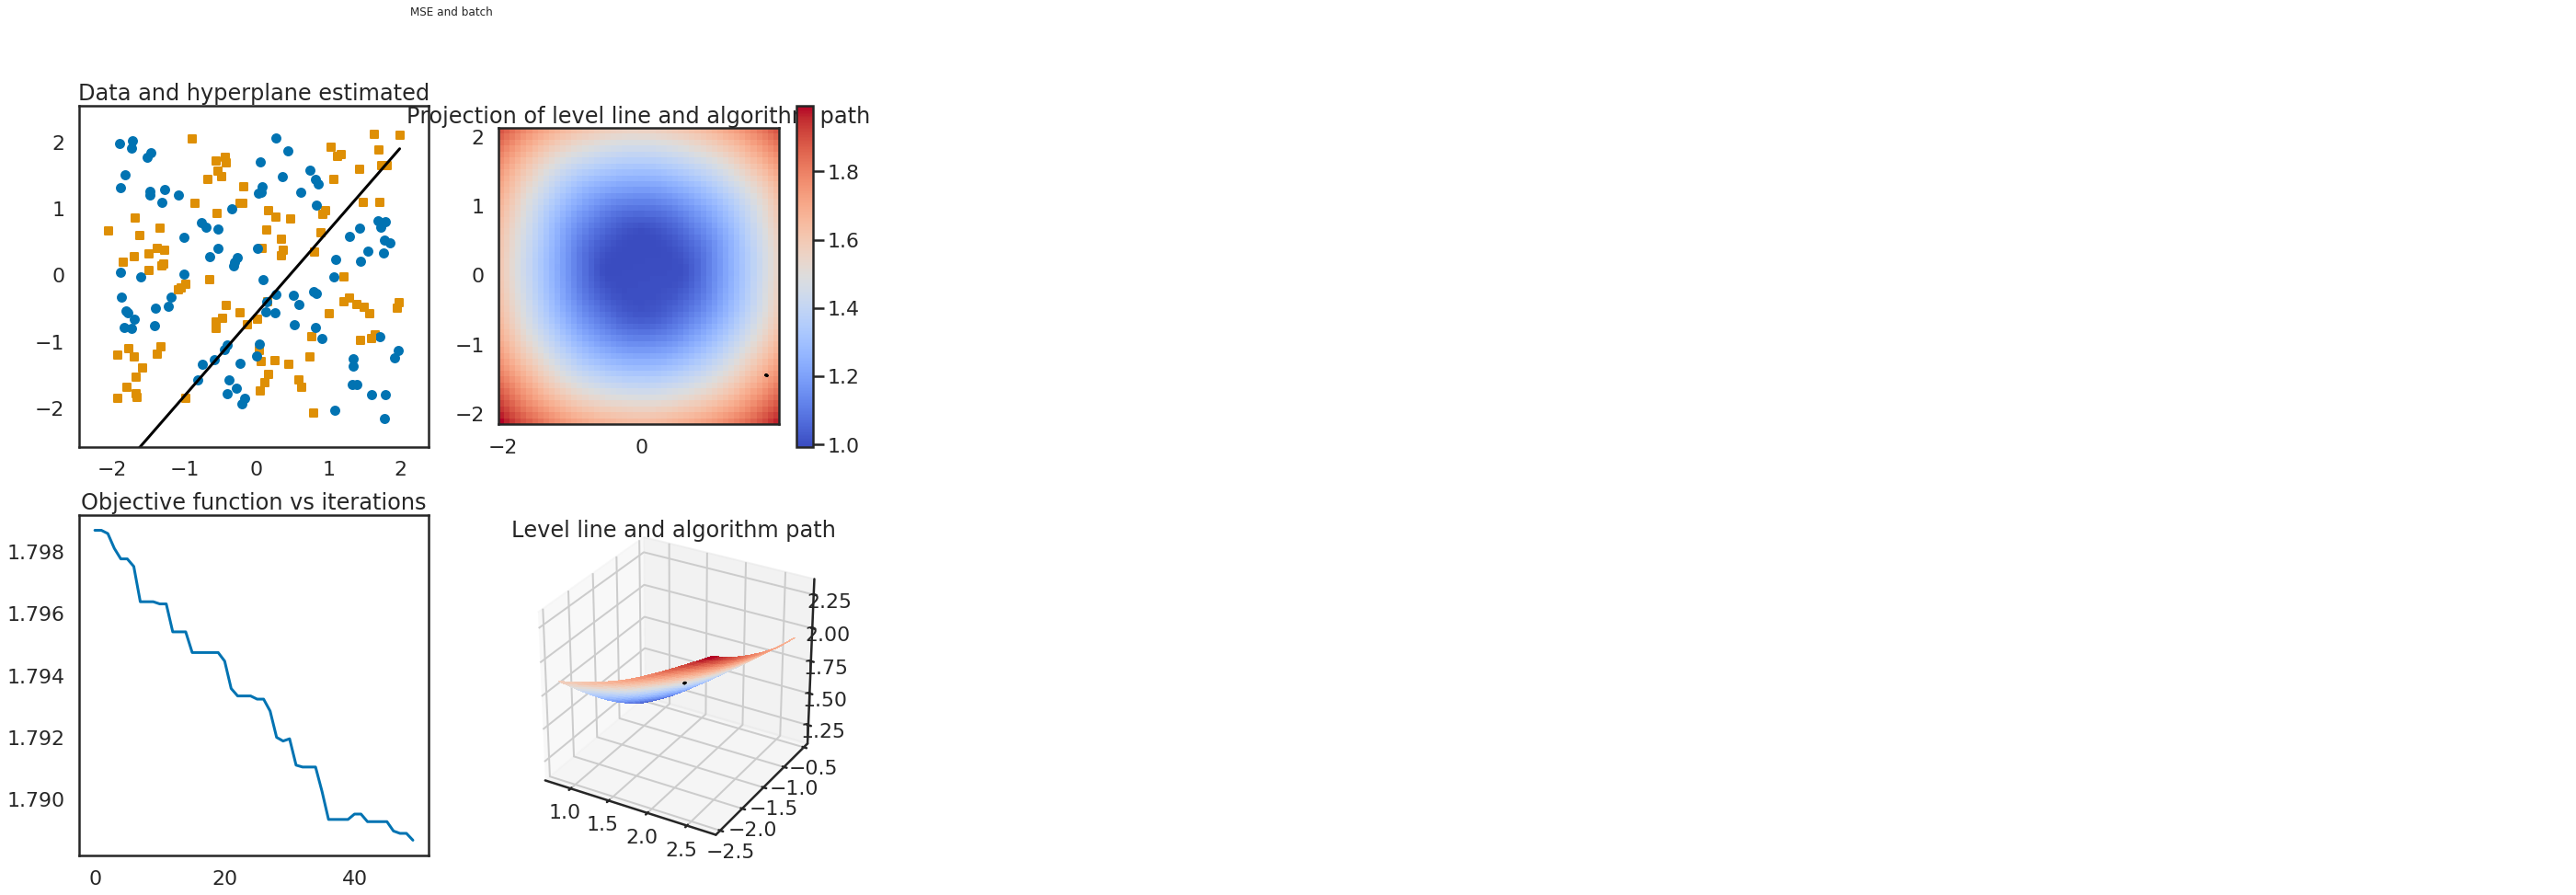

In [510]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = hinge_loss
gr_lfun = gr_hinge_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('Hinge and Stochastic', fontsize=12)
plt.show()

Selon le pas epsilon :

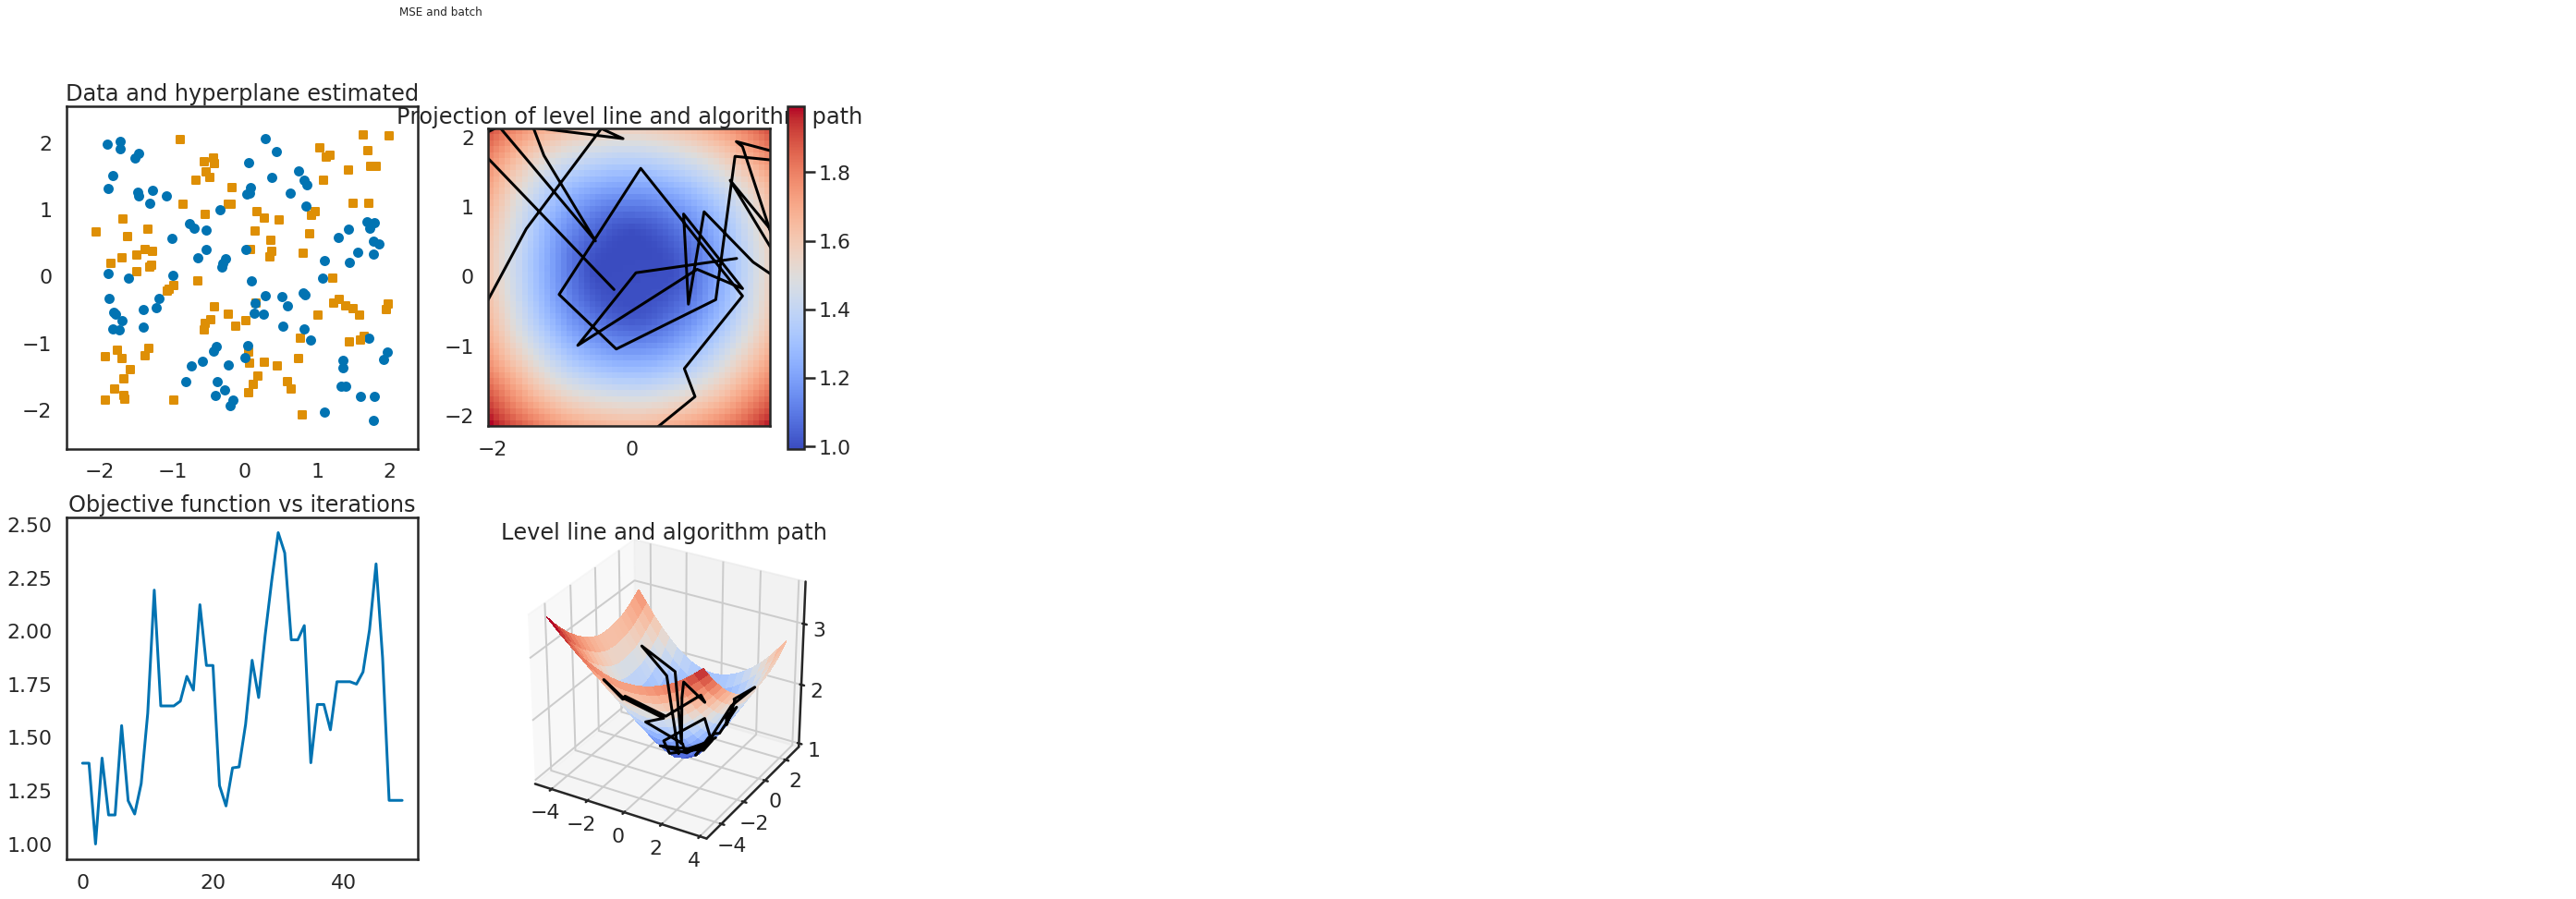

In [509]:
epsilon = 1
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = hinge_loss
gr_lfun = gr_hinge_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('Hinge and Stochastic', fontsize=12)
plt.show()

Dans ce cas précis, le pas choisi est trop grand et mène à une divergence de la descente de gradient.

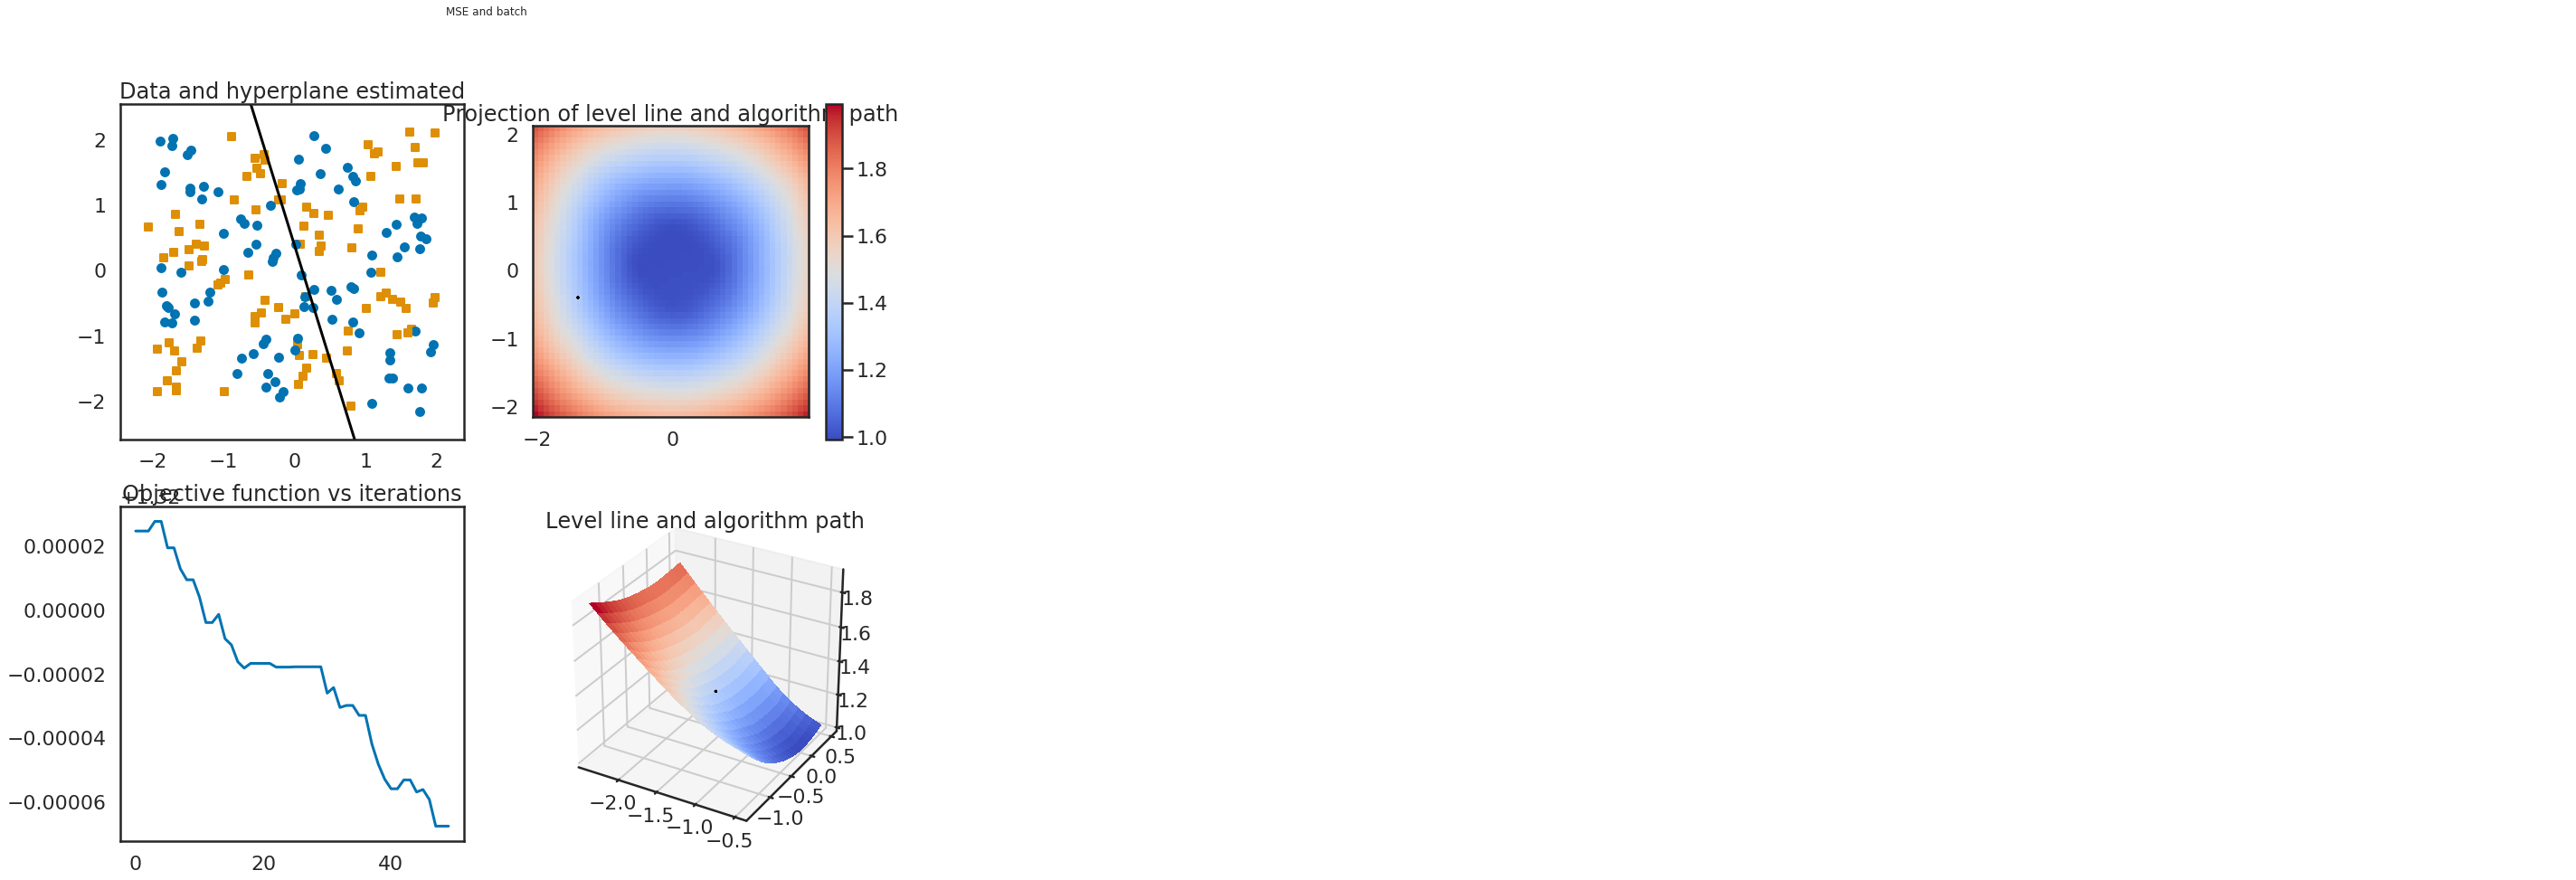

In [506]:
epsilon = 0.00001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = hinge_loss
gr_lfun = gr_hinge_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=True)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('Hinge and Stochastic', fontsize=12)
plt.show()

Dans cet autre cas, le pas est trop faible et la descente est trop lente.

### *Q7)* 
Étudiez comme précédemment le comportement de l’algorithme de descente de gradient, avec l’option
stoch=True désactivée.

Selon le nombre d'itérations :

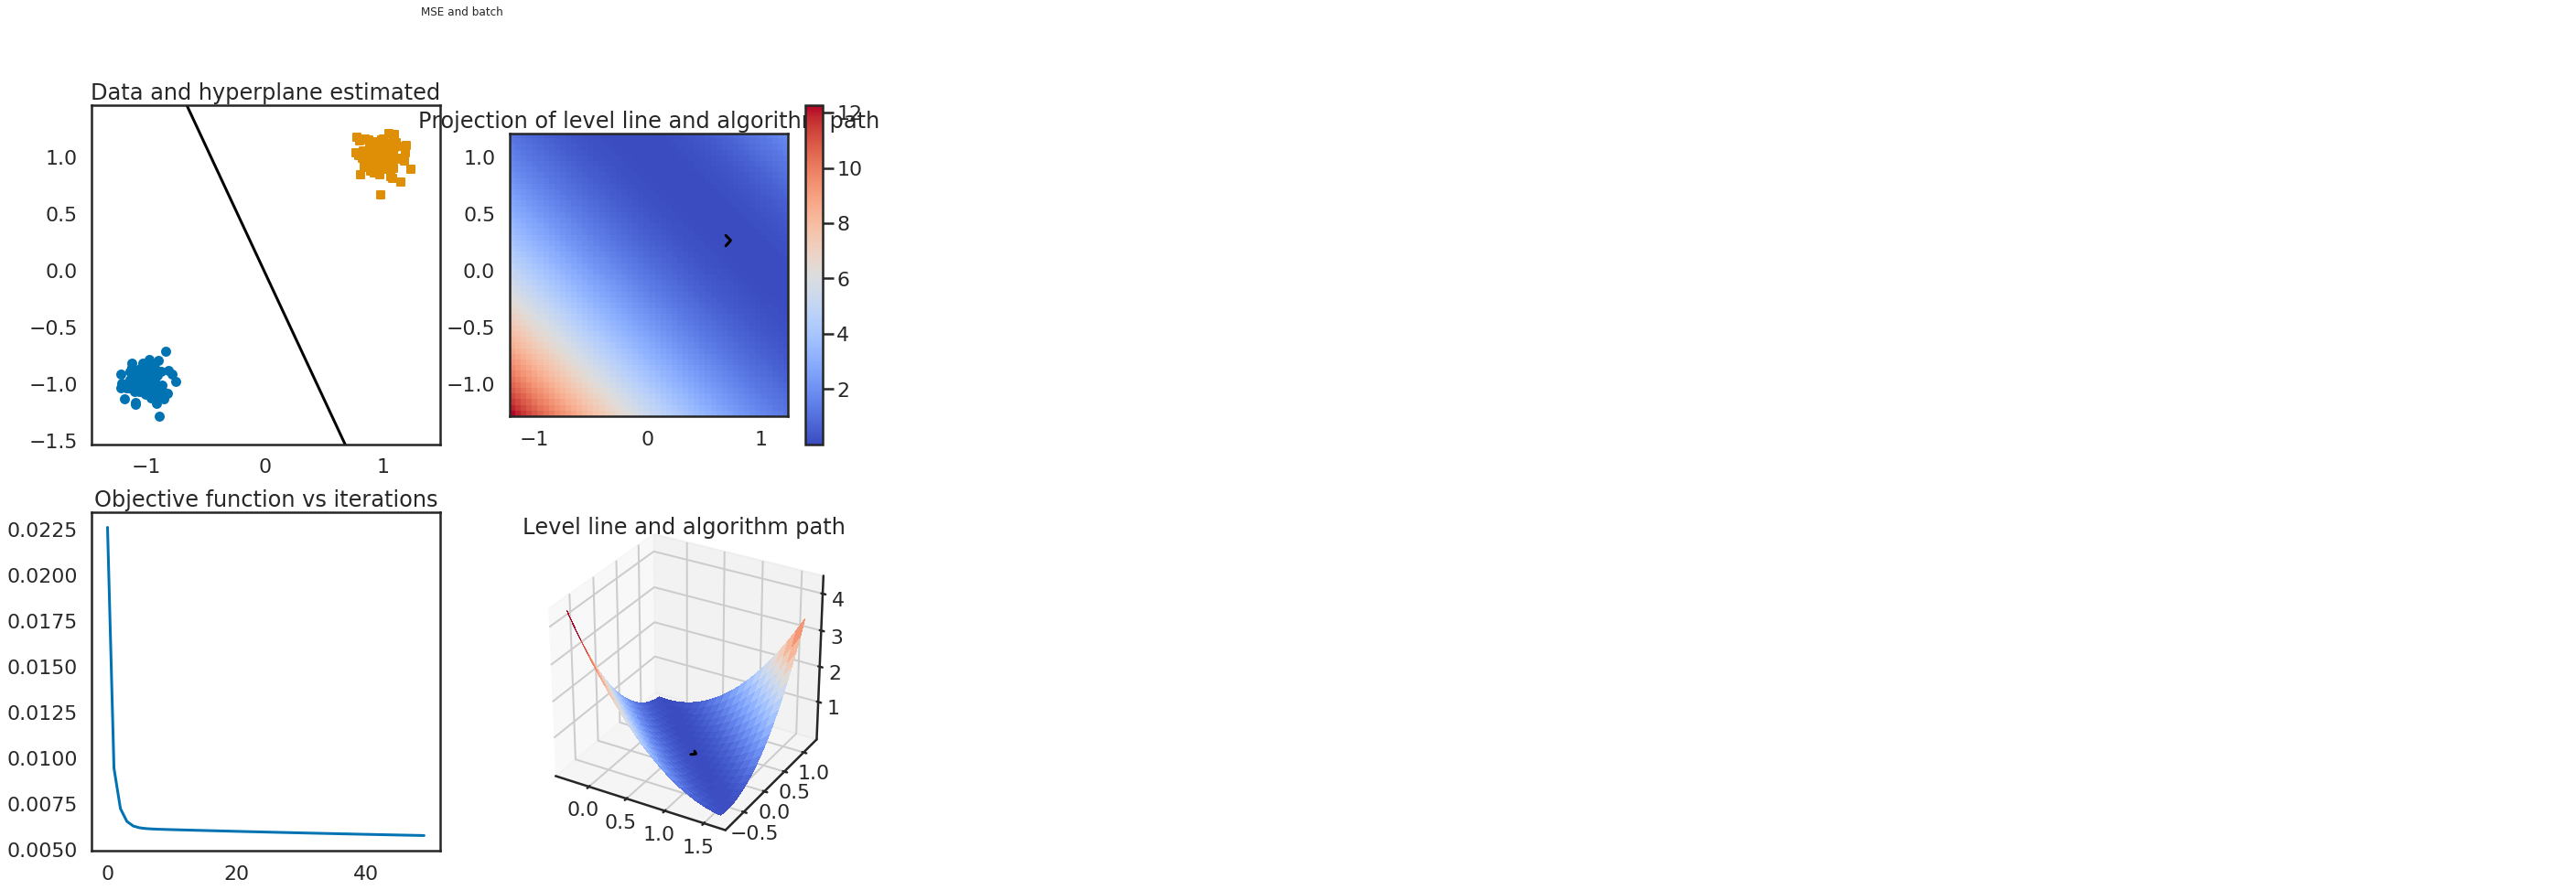

In [518]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_bi.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_bi, y_rand_bi, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_bi, y_rand_bi, wh, costh, lfun)
plt.suptitle('MSE and batch', fontsize=12)
plt.show()

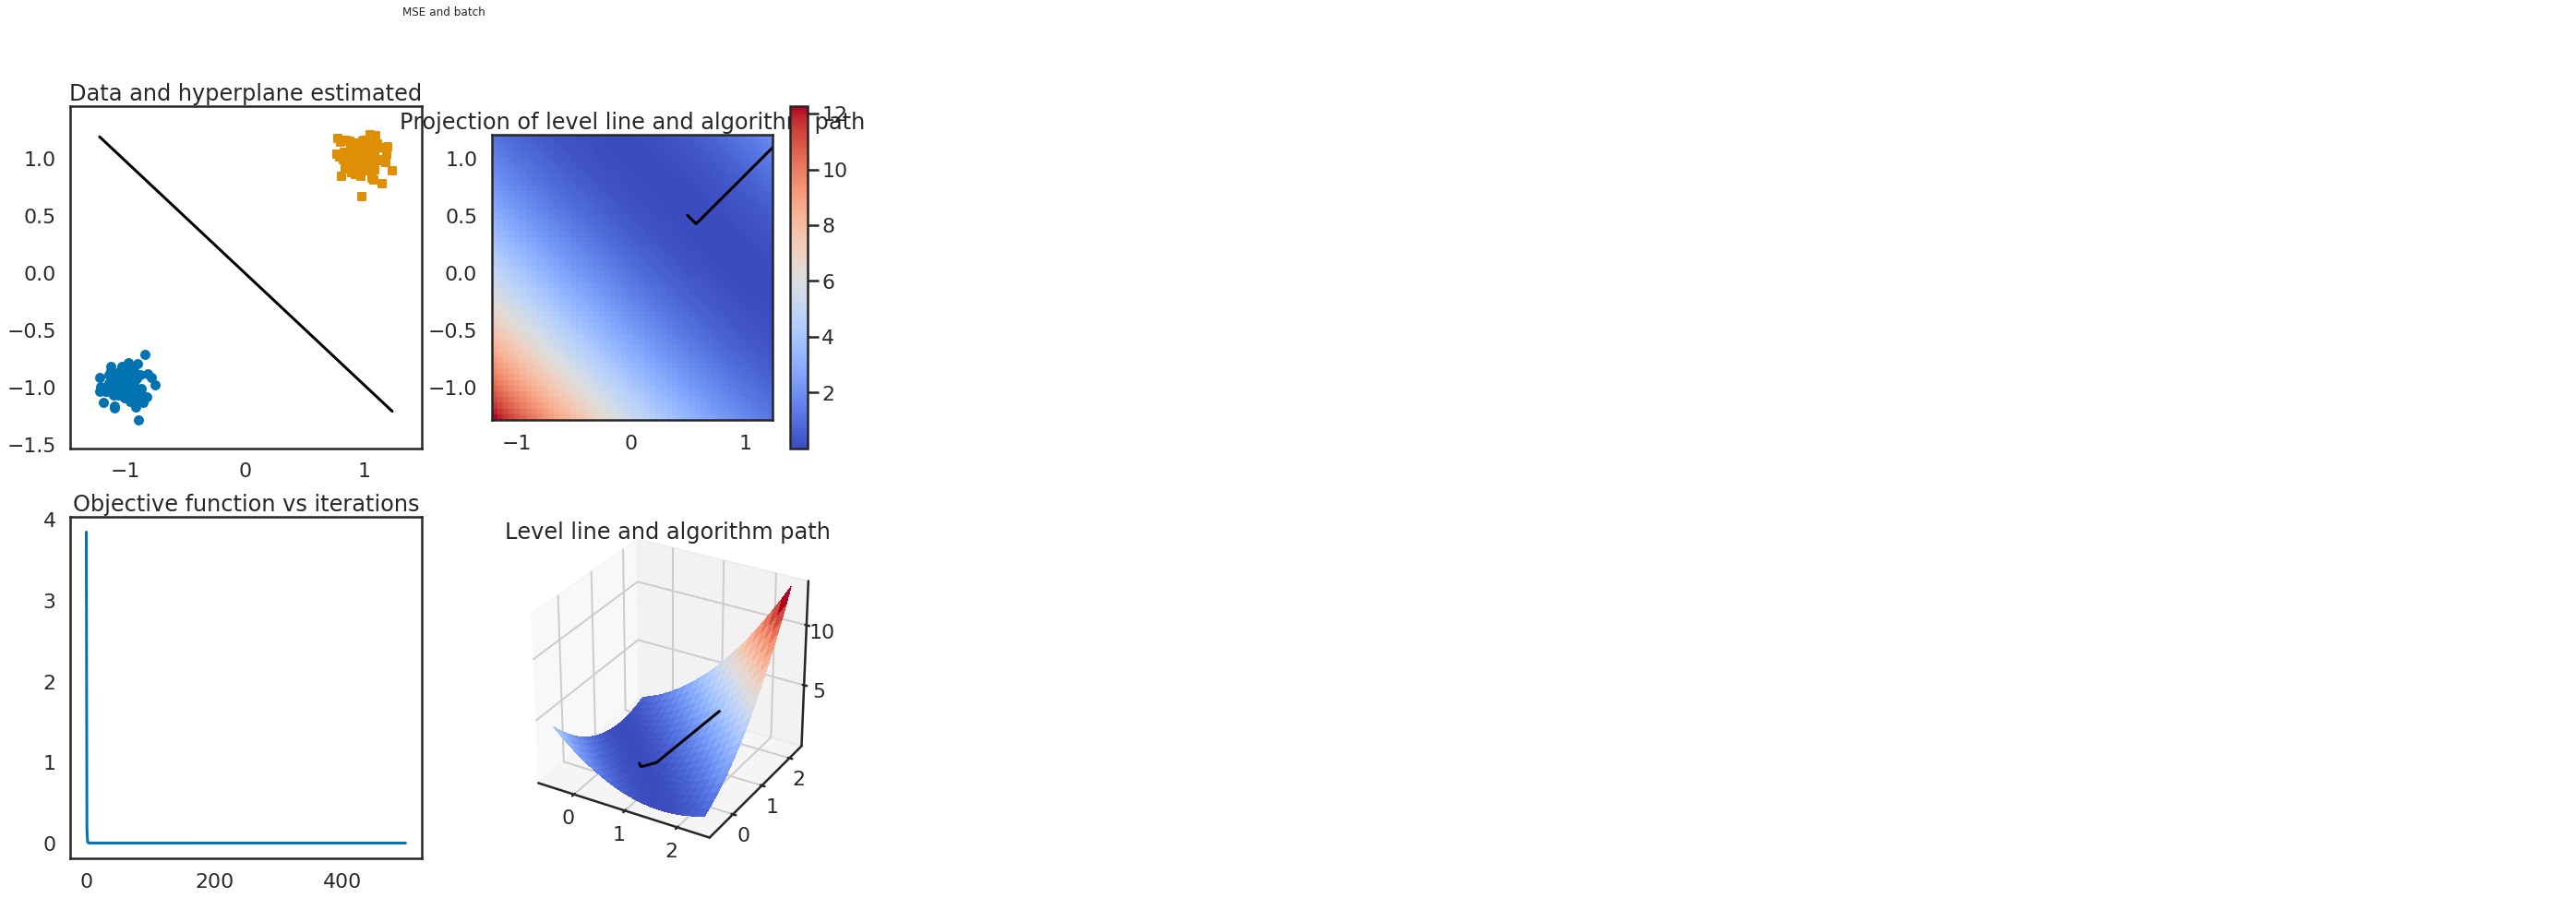

In [519]:
epsilon = 0.001
niter = 500
w_ini = np.random.randn(X_rand_bi.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_bi, y_rand_bi, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_bi, y_rand_bi, wh, costh, lfun)
plt.suptitle('MSE and batch', fontsize=12)
plt.show()

Selon la séparabilité des classes :

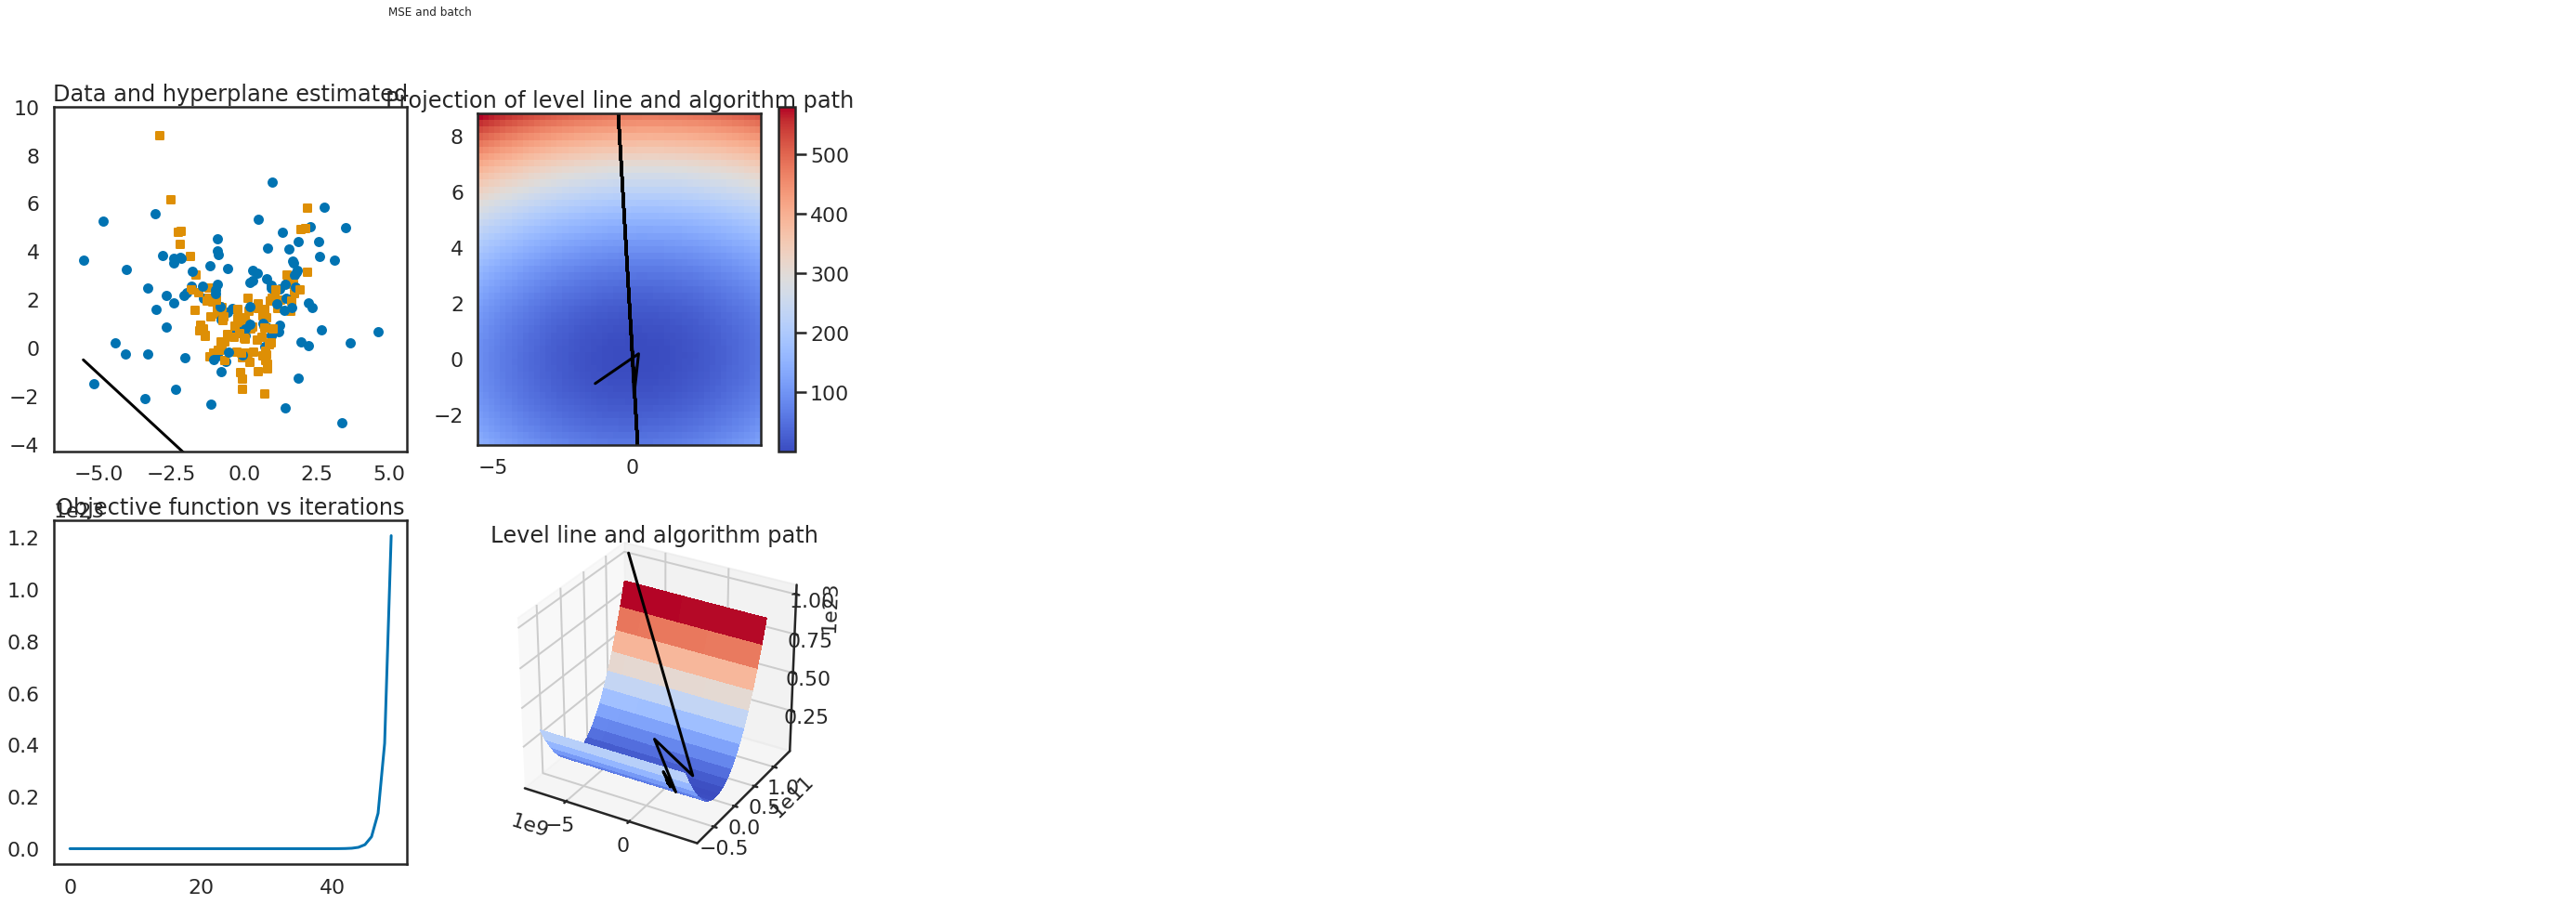

In [520]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_clown, y_rand_clown, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_clown, y_rand_clown, wh, costh, lfun)
plt.suptitle('MSE and batch', fontsize=12)
plt.show()

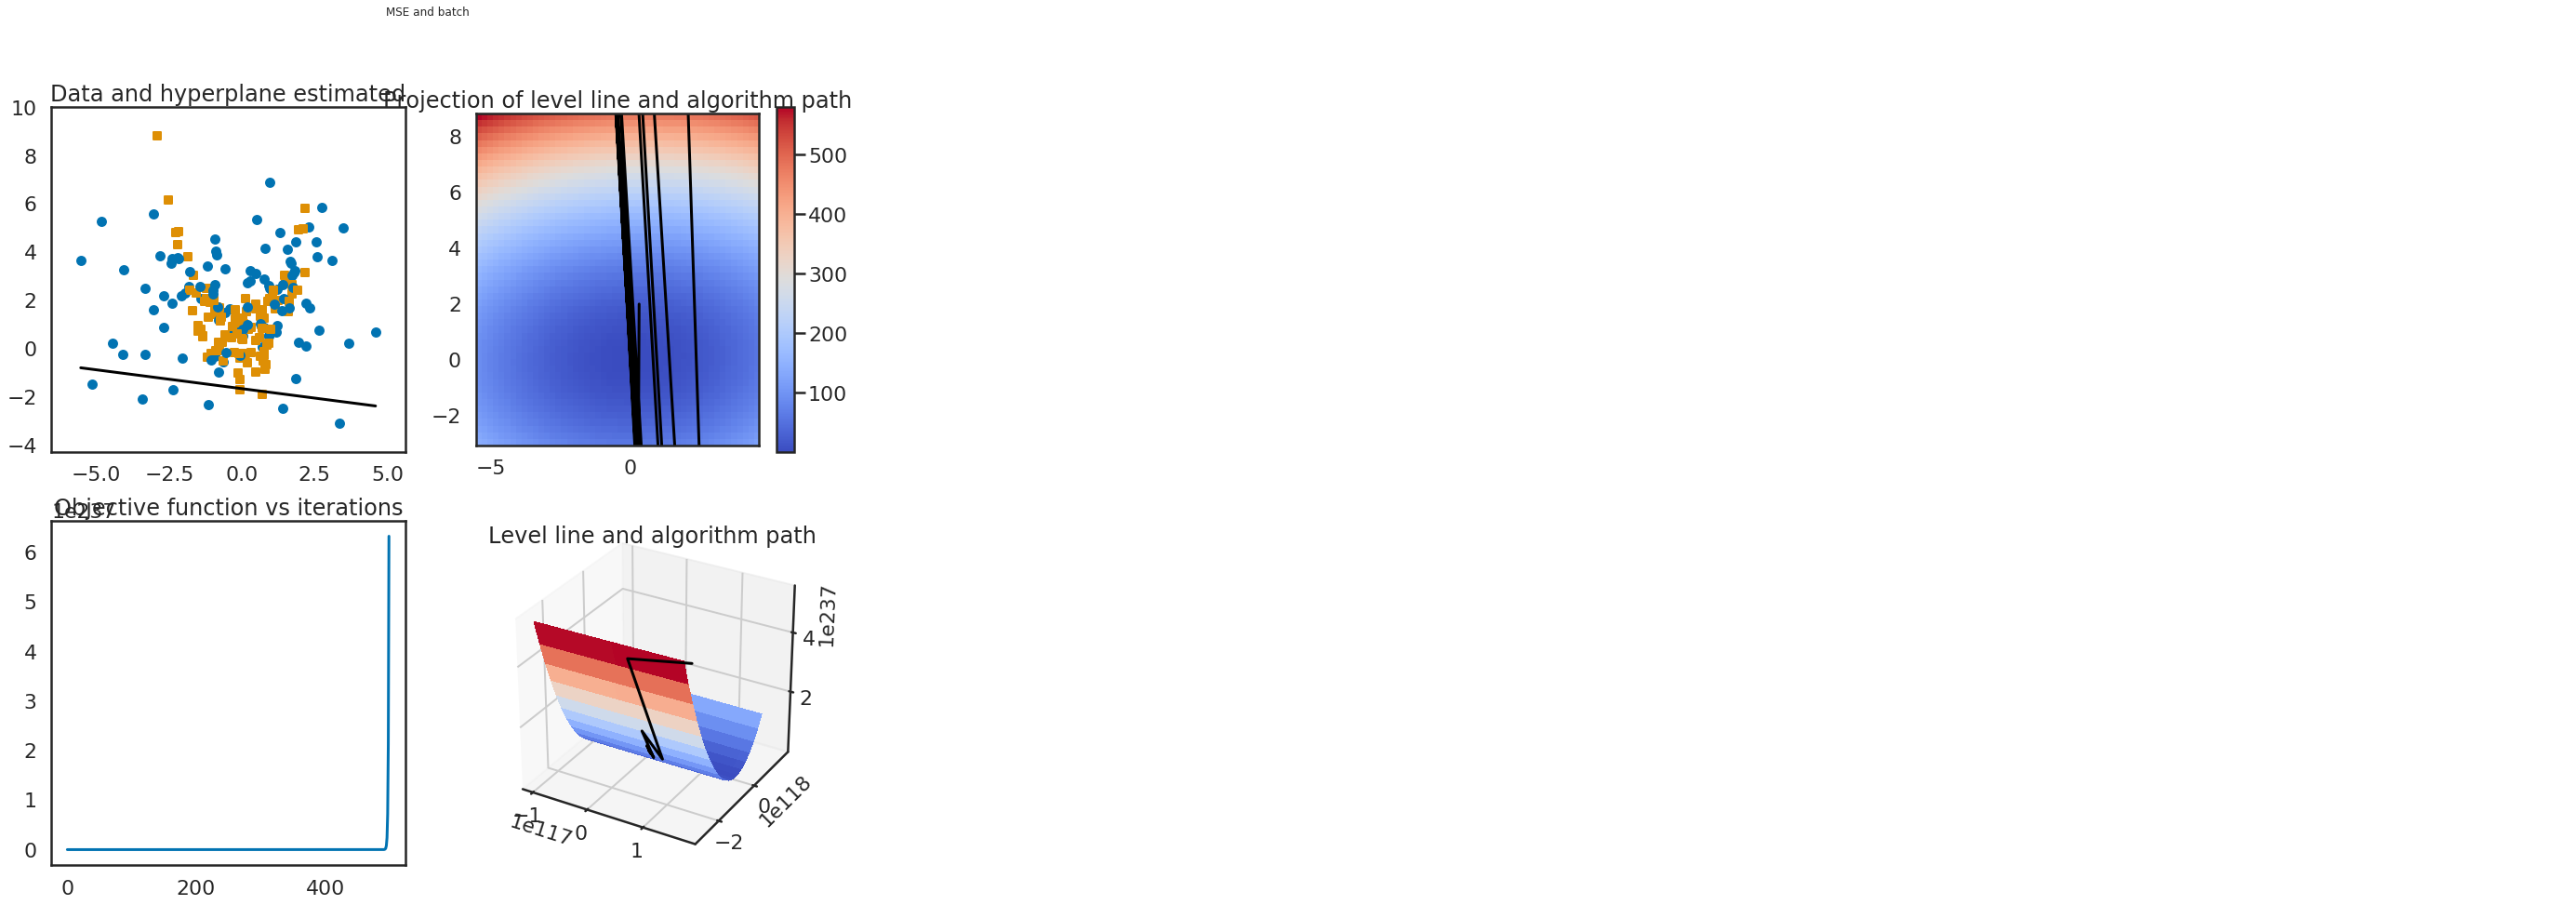

In [521]:
epsilon = 0.001
niter = 500
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_clown, y_rand_clown, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_clown, y_rand_clown, wh, costh, lfun)
plt.suptitle('MSE and batch', fontsize=12)
plt.show()

Selon la fonction de coût :

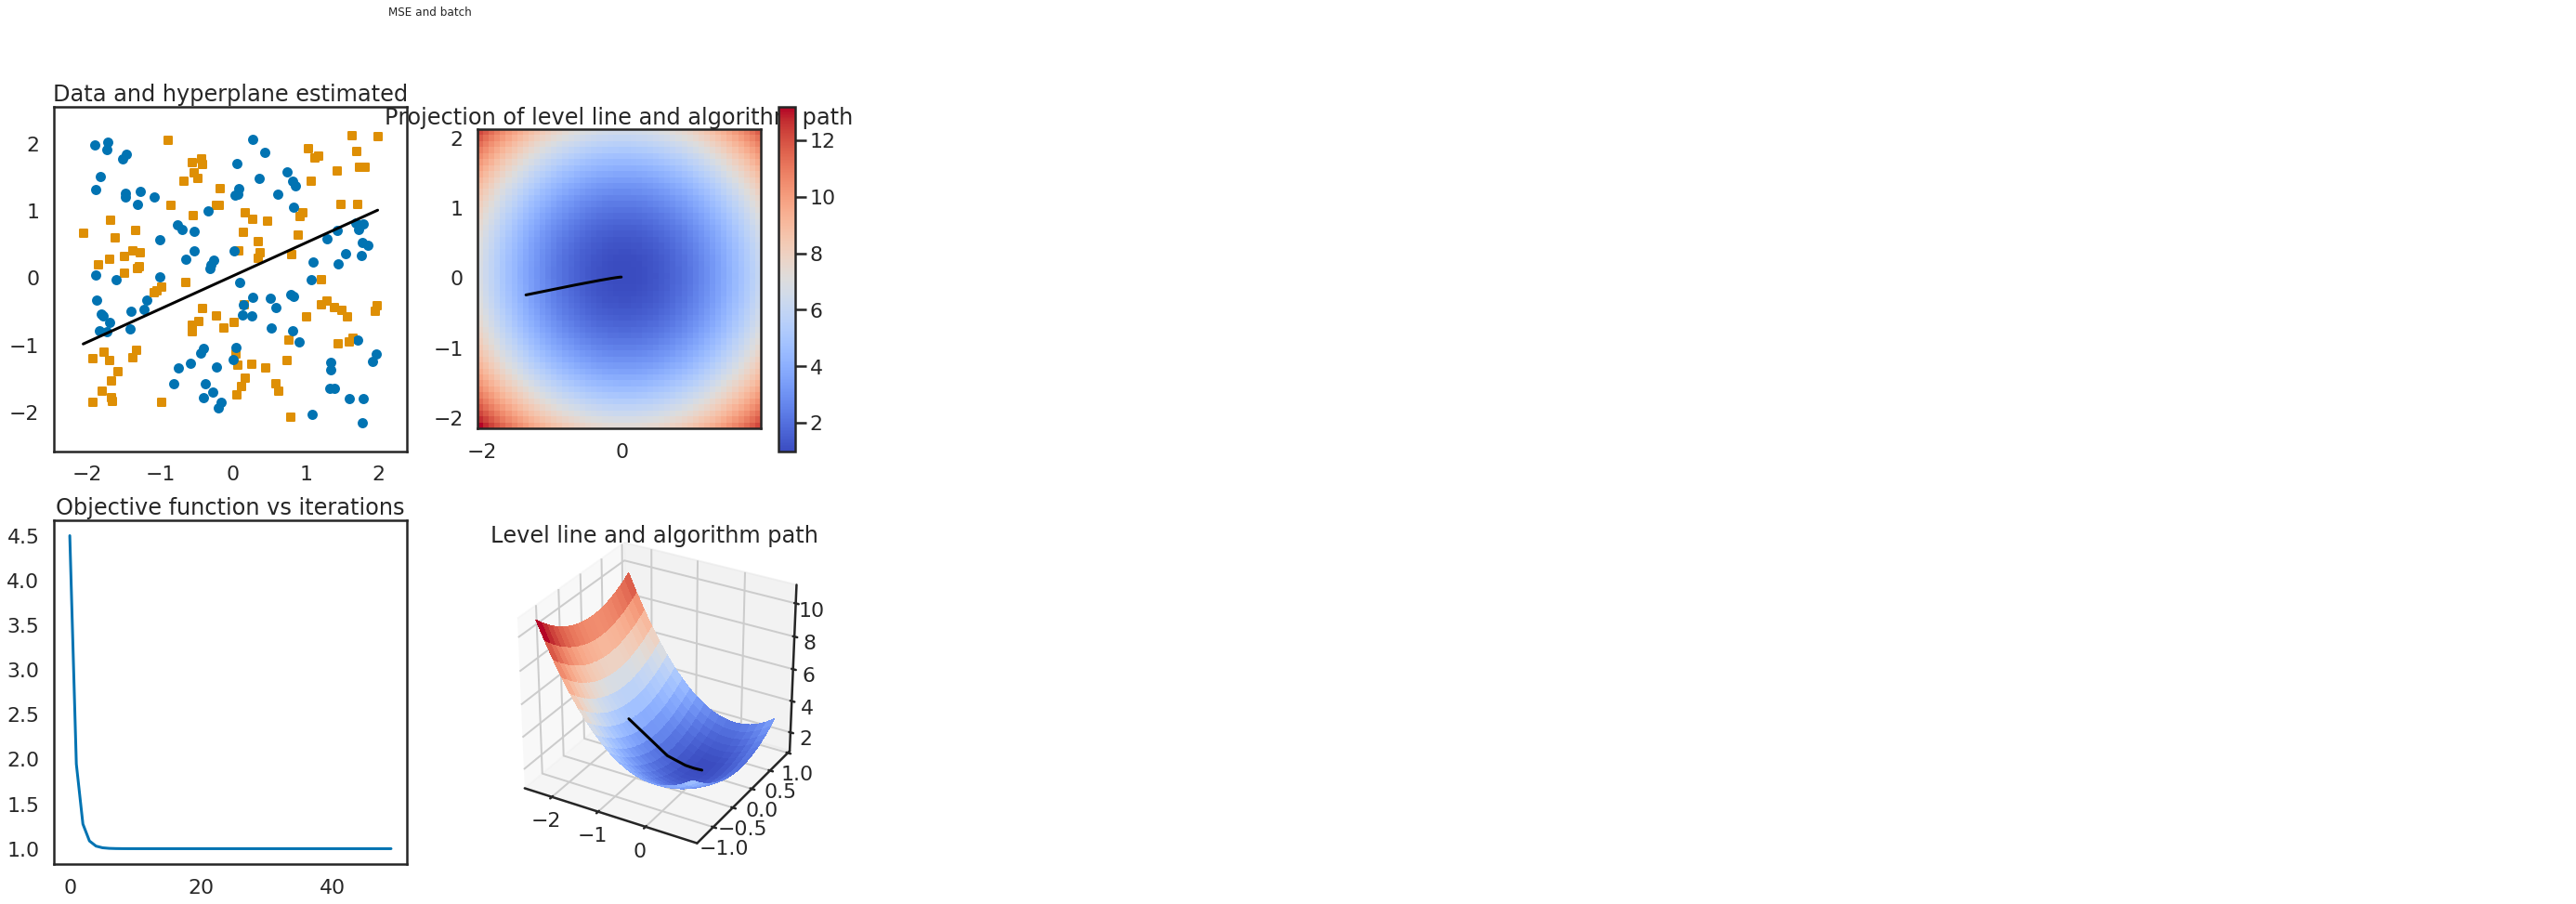

In [522]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = mse_loss
gr_lfun = gr_mse_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('MSE and batch', fontsize=12)
plt.show()

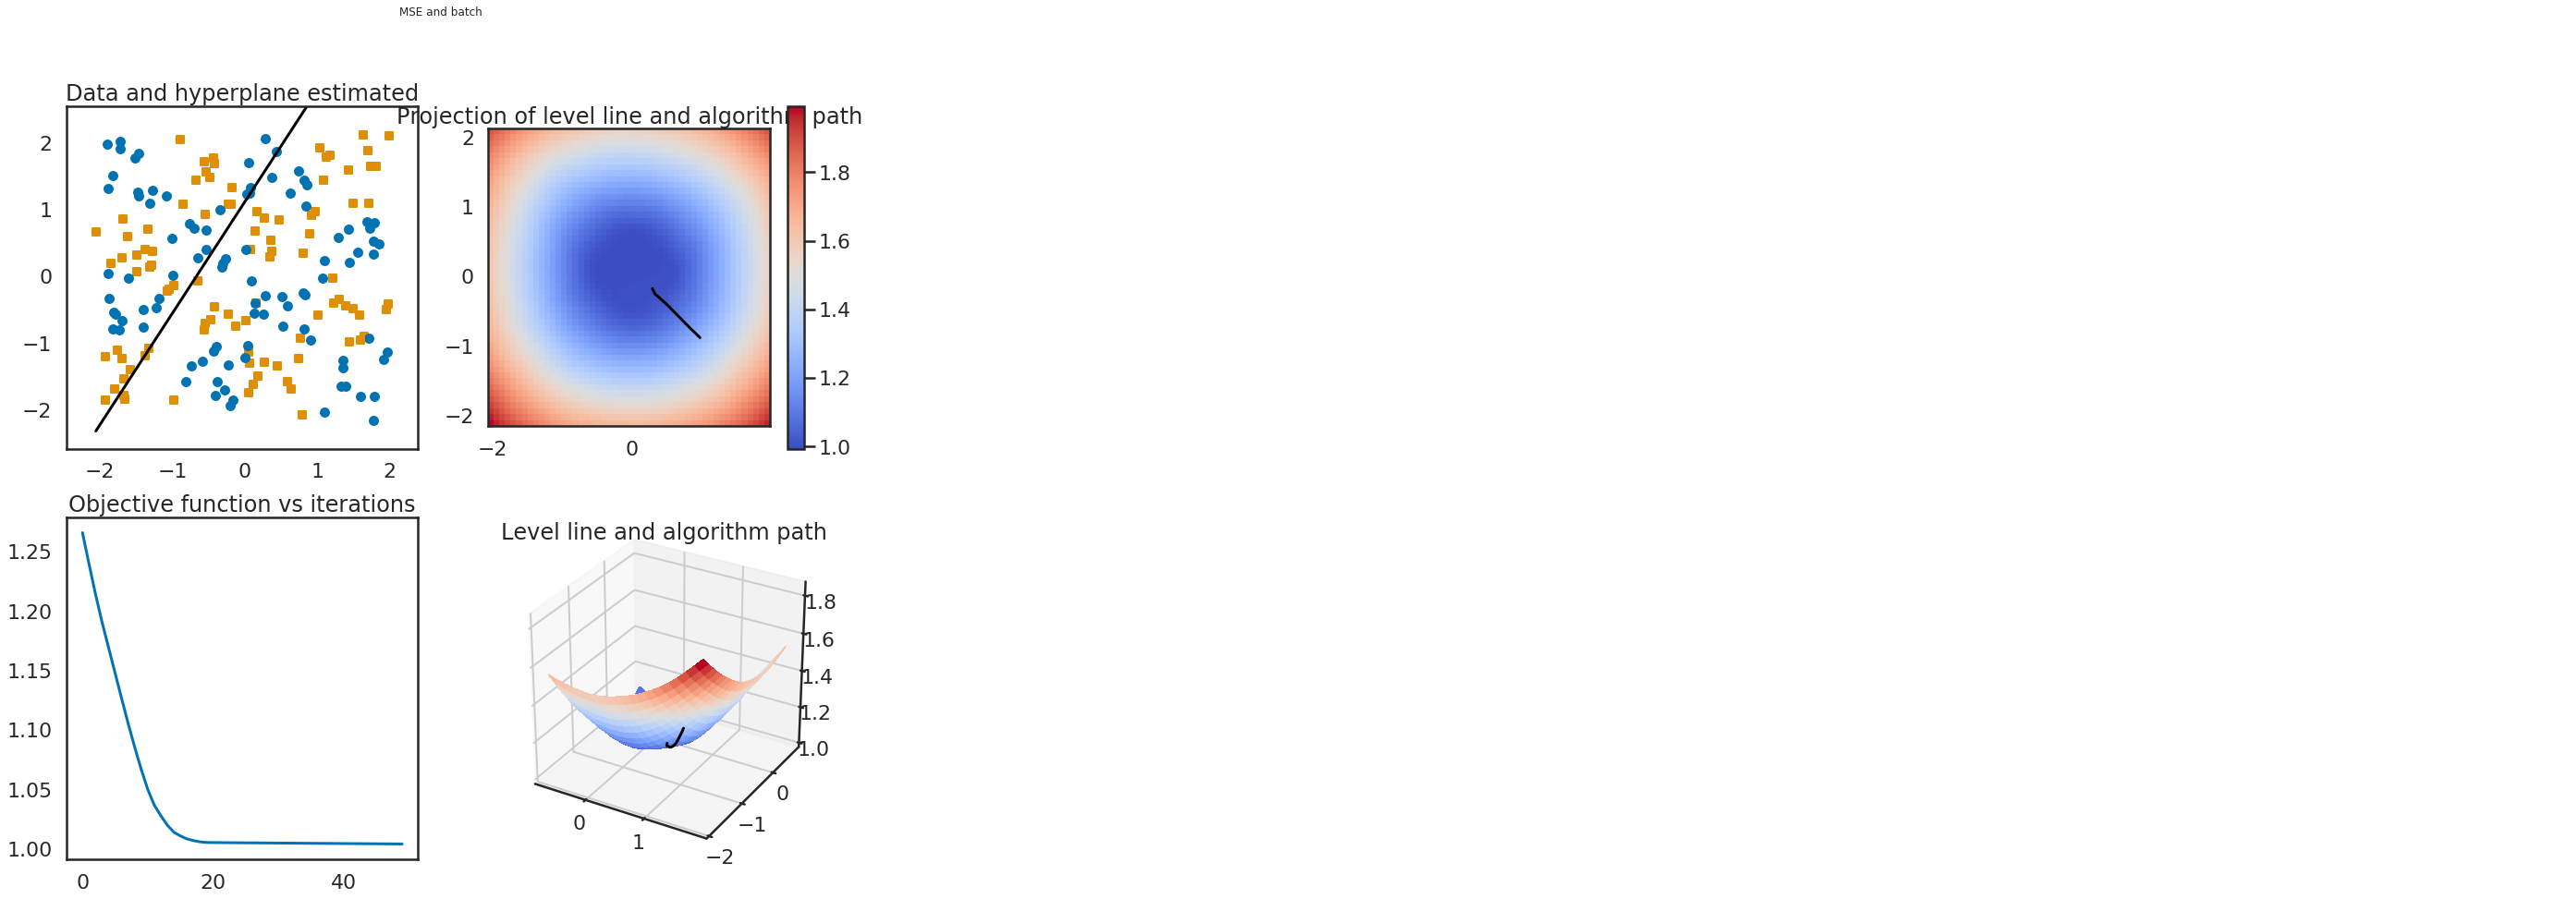

In [523]:
epsilon = 0.001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = hinge_loss
gr_lfun = gr_hinge_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('Hinge and batch', fontsize=12)
plt.show()

Selon le pas epsilon :

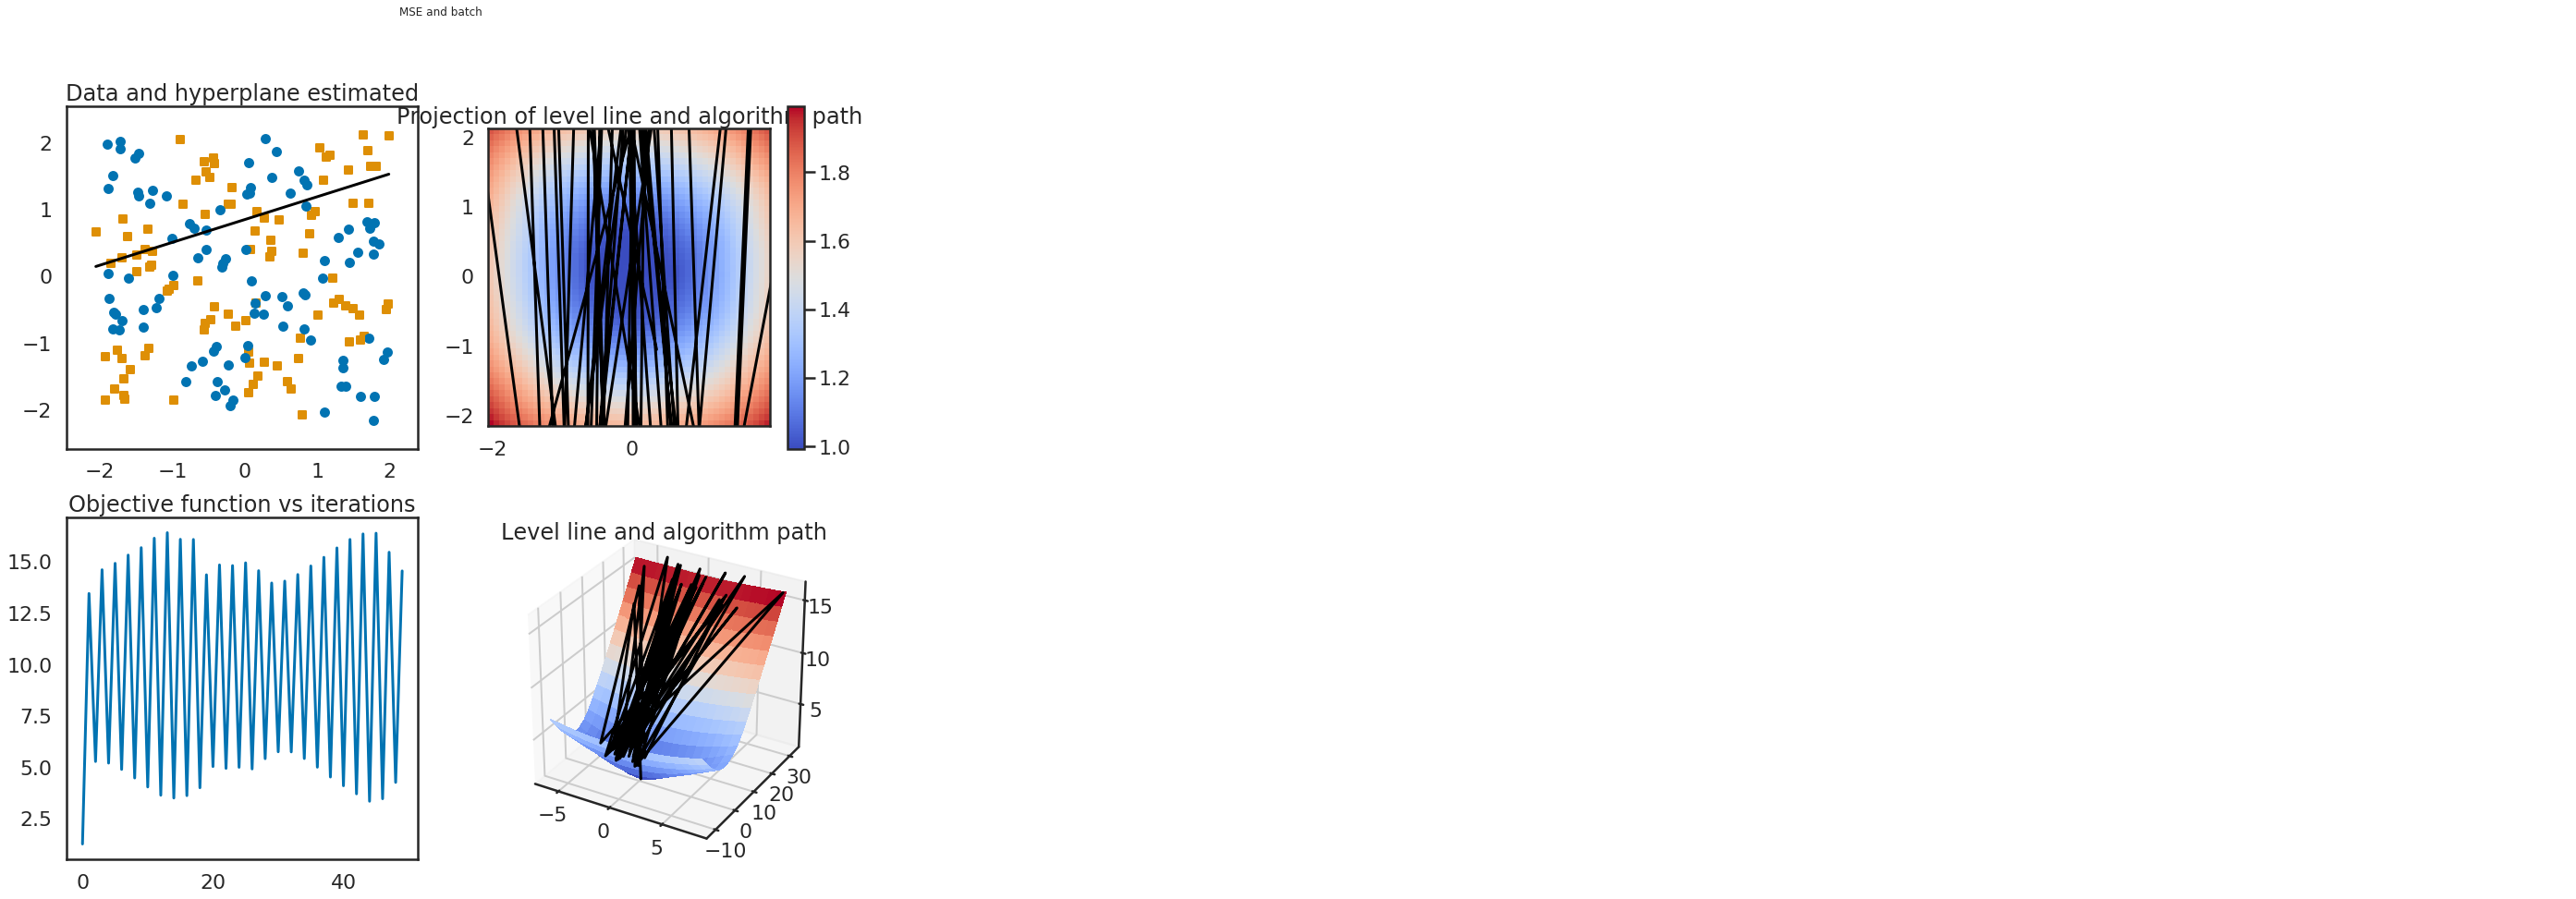

In [526]:
epsilon = 0.4
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = hinge_loss
gr_lfun = gr_hinge_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('Hinge and batch', fontsize=12)
plt.show()

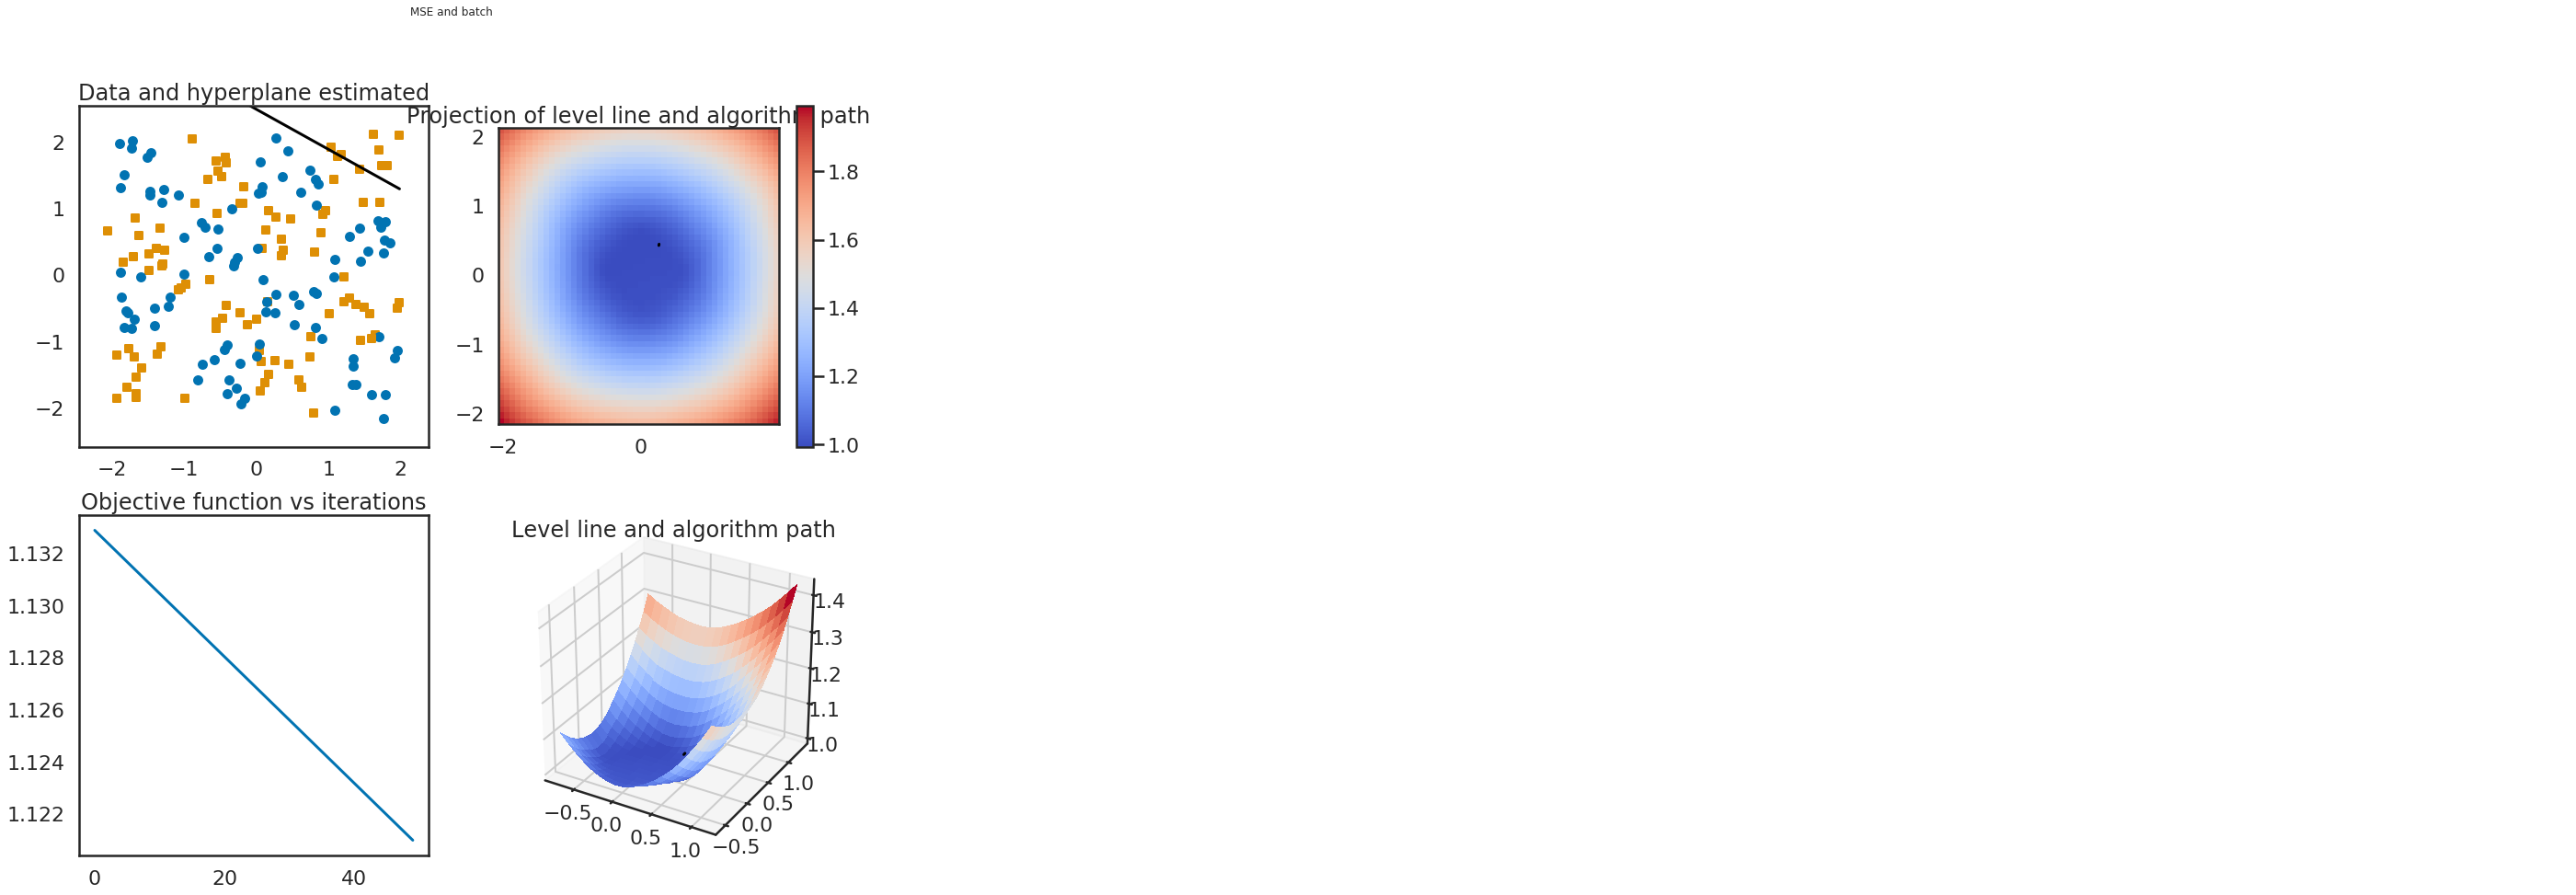

In [525]:
epsilon = 0.00001
niter = 50
w_ini = np.random.randn(X_rand_clown.shape[1] + 1)
lfun = hinge_loss
gr_lfun = gr_hinge_loss

plt.figure(figsize=(15,15))

wh, costh = gradient(X_rand_checkers, y_rand_checkers, epsilon, niter, w_ini, lfun, gr_lfun,stochastic=False)
plot_gradient(X_rand_checkers, y_rand_checkers, wh, costh, lfun)
plt.suptitle('Hinge and batch', fontsize=12)
plt.show()

### *Q8)*
Question optionnelle : étudiez numériquement la vitesse de convergence dans le cas suivant : les xi
sont des points uniformément repartis sur les segments {0} × [0, M] (alors les yi valent 1) ou bien
sur le segment {δ} × [0, M] (alors les yi valent −1). De plus la proportion de 1 est égale à 1/2. On
regardera l’impact de δ, M et n sur le temps de convergence du perceptron.

In [540]:
def rand_bi_uni(M=1000):
    
    ex1 = np.random.uniform(0, M)
    ex2 = np.random.uniform(0, M)
    y = np.hstack([np.ones(M), -1 * np.ones(M)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(2)
    return X[ind, :], y[ind]

In [541]:
rand_bi_uni()

(array([[840.91745114],
        [ 30.2299253 ]]), array([1., 1.]))

### *Q9)*
Proposez/codez des variantes de conditions d’arrêt pour l’algorithme

Une variante pourrait être de continuer à converger tant que la la différence entre w[i,:] et w[i-1,:] est supérieure à un seuil prédéfini.

In [558]:
def gradient_seuil(x, y, eps, seuil, w_ini, loss_fun, gr_loss_fun, stochastic=True):
    """ algorithme de descente du gradient:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        - loss_fun : fonction de cout
        - gr_loss_fun : gradient de la fonction de cout
        - stoch : True : gradient stochastique
        """
    w = []
    #np.zeros((niter, w_ini.size))
    w.append(w_ini)
    loss = []
    #np.zeros(niter)
    loss.append(loss_fun(x, y, w[0]).mean())
    i=0
    while abs(w[i] - w[i-1]) > seuil :
        if stochastic:  # this is for Stochastic Gradient Descent
            idx = [np.random.randint(x.shape[0])]
        else:           # this is for pure Gradient Descent
            idx = np.arange(x.shape[0])
        w.append(w[i - 1, :] - eps * gr_loss_fun(x[idx, :],y[idx], w[i - 1, :]))
        loss.append(loss_fun(x, y, w[i, :]).mean())
        i=i+1
    return w, loss

In [560]:
wh, costh = gradient_seuil(X_rand_bi, y_rand_bi, 0.01, niter, w_ini, lfun, gr_lfun,stochastic=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### *Q10)*
Afficher sur une même figure l’évolution des frontières en fonctions des itérations. On pourra utiliser
la fonction plot_2d et son argument alpha_choice pour cela.

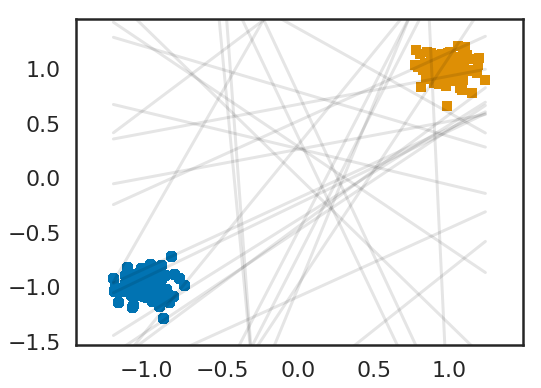

In [579]:
niter = 30
for i in range(niter):
    plot_2d(X_rand_bi, y_rand_bi, w=np.random.randn(X_rand_bi.shape[1] + 1), step = 30, alpha_choice=0.1)

### *Q11)*
Question optionnelle : trouver un fonction de perte telle que l’algorithme du perceptron soit équivalent
à la version donnée par l’Algorithme 2 (qui est la version initiale de l’algorithme). Interprétez
la condition suivante : fw(xi) · yi ≤ 0.

La condition fw(xi)·yi ≤ 0 indique que la descente n'a lieu que pour les Xi tels que la fonction de perte associé à ce point mutliplitée par les yi nous donne un résultat négatif.

### *Q12)*
Quelle est la formule analytique d’une ellipse, d’une hyperbole et d’une parabole en 2D ?

- La parabole est la courbe d'équation cartésienne : y = f(x) associée au trinôme du second degré f(x) = ax^2 + bx + c
- L'hyperbole est une courbe plane obtenue comme la double intersection d'un double cône de révolution avec un plan :  x^2/ a^2 - y^2/ b^2 = 1 
- Une ellipse est une courbe plane fermée obtenue par l’intersection d’un cône de révolution avec un plan, à condition que celui-ci coupe l'axe de rotation du cône ou du cylindre : c'est une conique d'excentricité strictement comprise entre 0 et 1 : x^2/ a^2 + y^2/ b^2 = 1 

### *Q13)*
Proposez une méthode pour réussir à classifier le jeu de données clown en créant des interactions
d’ordre deux. En pratique, peut-on généraliser au delà de l’ordre deux facilement ? On pourra
utiliser la fonction poly2 du fichier source, qui plonge les données bi-dimensionnelles dans l’espace
des fonctions polynomiales de degré 2 en les données.

In [580]:
###############################################################################
#                Polynomial transformations
###############################################################################


def poly2(x):
    """ creates features for second order interactions """
    if x.ndim == 1:
        x = x[None, :]
    nb, d = x.shape
    res = x
    for i in range(0, d):
        for j in range(i, d):
            res = np.hstack((res, x[:, i:i + 1] * x[:, j:j + 1]))
    return res


def poly3(x):
    """ creates features for third order interactions """
    if x.ndim == 1:
            x = x[None, :]
    nb, d = x.shape
    res = poly2(x)
    for i in range(0, d):
        for j in range(i, d):
            for k in range(j, d):
                res = np.hstack(
                    (res, x[:, i:i + 1] * x[:, j:j + 1] * x[:, k:k + 1]))
    return res


Pour créer des intéractions d'ordre 2 et classifier nos données, il faut transformer les données X en dimension 2. Cette approche peut se fait via la fonction poly2. 

In [586]:
X_rand_clown2 = poly2(X_rand_clown)
y_rand_clown2 = poly2(y_rand_clown2)

### *Q14)* 
Sur le jeu de données clown, faites quelques expériences en transformant vos données et tracez les
frontières de décision.

In [583]:
###############################################################################
#            Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """Frontiere plotting for a decision function f."""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()


def frontiere_new(clf, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True, n_labels=3, n_neighbors=3):
    """Trace la frontiere pour la fonction de decision de clf."""
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    XX = np.c_[xx.ravel(), yy.ravel()]
    print(XX.shape)
    z = clf.predict(XX)
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    # color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    # sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)
    plt.title("L=" + str(n_labels) + ",k=" +
              str(n_neighbors))


def frontiere_3d(f, data, step=20):
    """Plot the 3d frontiere for the decision function f."""
    ax = plt.gca(projection='3d')
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    ax.plot_surface(xx, yy, z, rstride=1, cstride=1,
                    linewidth=0., antialiased=False,
                    cmap=plt.cm.coolwarm)


def plot_cout(X, y, loss_fun, w=None):
    """Plot the cost function encoded by loss_fun,

    Parameters
    ----------
    X : data features
    y :  labels
    loss_fun : loss function
    w : (optionnal) can be used to give a historic path of the weights """
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(X, y, ww).mean()
    datarange = np.array([[np.min(X[:, 0]), np.min(X[:, 1])],
                          [np.max(X[:, 0]), np.max(X[:, 1])]])
    frontiere(_inter, np.array(datarange))
    if w is not None:
        plt.plot(w[:, 1], w[:, 2], 'k')
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])


def plot_cout3d(x, y, loss_fun, w):
    """ trace le cout de la fonction cout loss_fun passee en parametre, en x,y,
        en faisant varier les coordonnees du poids w.
        W peut etre utilise pour passer un historique de poids"""
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(x, y, ww).mean()

    datarange = np.array([[w[:, 1].min(), w[:, 2].min()],
                         [w[:, 1].max(), w[:, 2].max()]])
    frontiere_3d(_inter, np.array(datarange))
    plt.plot(w[:, 1], w[:, 2], np.array([_inter(w[i, 1:]) for i in
             range(w.shape[0])]), 'k-', linewidth=3)


In [589]:
plot_2d(X_rand_clown2, y_rand_clown, w=np.random.randn(X_rand_clown2.shape[1] + 1), step = 30, alpha_choice=0.1)

IndexError: too many indices for array